<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1765098/3617292956.py:22: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(msd_file, comment='#', sep='\s+', header=None)


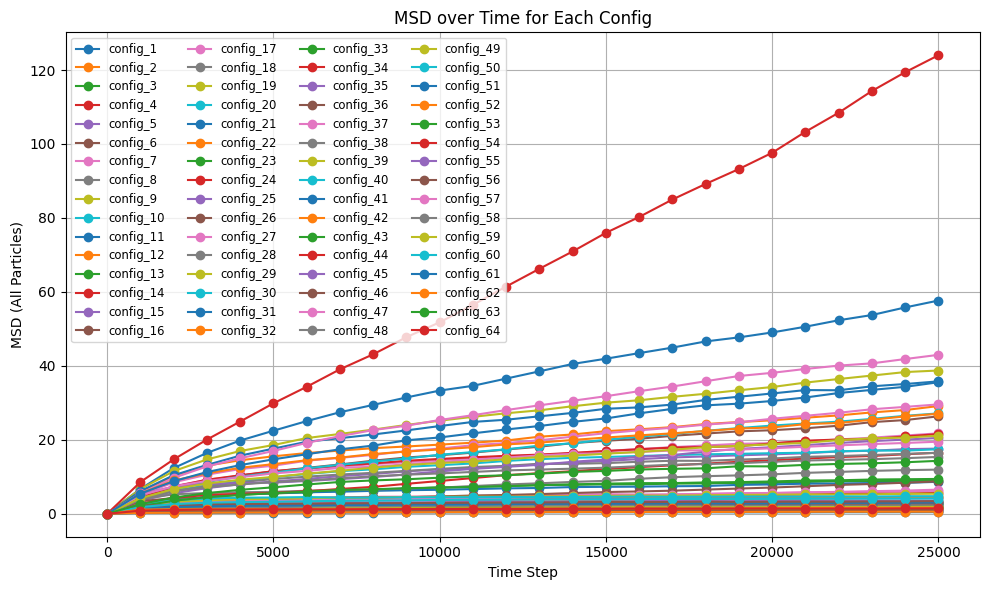

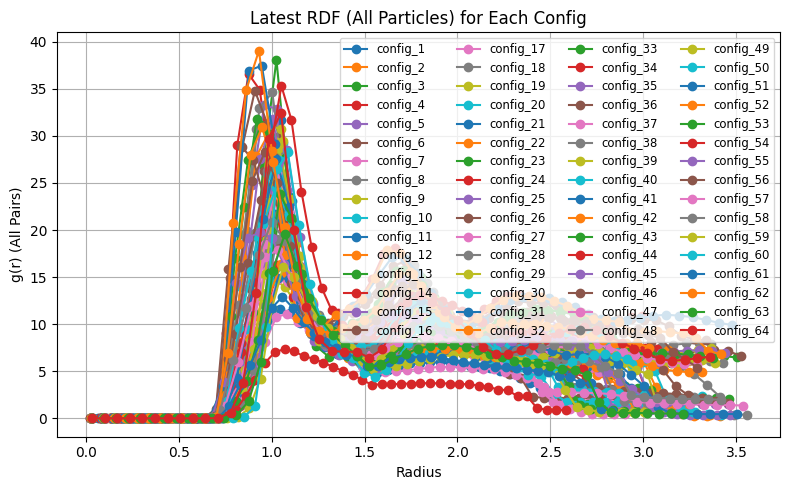

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt

#########################################
# 1. Get list of configuration folders.
#########################################
base_dir = '.'  # Adjust if your config folders are elsewhere.
configs = [d for d in os.listdir(base_dir)
           if d.startswith('config_') and os.path.isdir(os.path.join(base_dir, d))]
# Sort them numerically (e.g., config_1, config_2, …, config_64)
configs.sort(key=lambda x: int(x.split('_')[1]))

#########################################
# 2. Plot the full MSD time series for each config.
#########################################
plt.figure(figsize=(10, 6))
for config in configs:
    msd_file = os.path.join(base_dir, config, 'msd_adapt.out')
    if os.path.isfile(msd_file):
        # Read MSD file, skipping comment lines (those starting with '#')
        data = pd.read_csv(msd_file, comment='#', sep='\s+', header=None)
        # Assign column names based on the file structure.
        data.columns = ["TimeStep", "v_msd_all_val", "v_msd_1_val", "v_msd_8_val", "v_msd_9_val"]
        # Plot the MSD for all particles.
        plt.plot(data["TimeStep"], data["v_msd_all_val"], marker='o', label=config)

plt.xlabel("Time Step")
plt.ylabel("MSD (All Particles)")
plt.title("MSD over Time for Each Config")
# Using many configs may clutter the legend; adjust fontsize/ncols as needed.
plt.legend(fontsize='small', ncol=4)
plt.grid(True)
plt.tight_layout()
plt.show()

#########################################
# 3. Function to parse the RDF file into time blocks.
#########################################
def parse_rdf_file(filename):
    """
    Parse the rdf.out file into blocks.
    
    Each block starts with a header line: "TimeStep Number-of-rows"
    followed by that many data rows. Each data row is expected to contain 10 numbers:
      1)  index,
      2)  radial distance (bin center),
      3)  g(r) for pair #1,
      4)  coordination for pair #1,
      5)  g(r) for pair #2,
      6)  coordination for pair #2,
      7)  g(r) for pair #3,
      8)  coordination for pair #3,
      9)  g(r) for pair #4,
      10) coordination for pair #4.
    
    Columns are labeled as:
      ["index", "radius", "g(r1)", "c(1)", "g(r2)", "c(2)", "g(r3)", "c(3)", "g(r4)", "c(4)"]
      
    Returns a dictionary mapping timestep (float) -> pandas DataFrame (one block per timestep).
    """
    blocks = {}
    with open(filename, "r") as f:
        lines = f.readlines()
    
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        # Skip empty or comment lines.
        if not line or line.startswith("#"):
            i += 1
            continue
        
        tokens = line.split()
        # Block header: two tokens (TimeStep and Number-of-rows)
        if len(tokens) == 2:
            timestep = float(tokens[0])
            nrows = int(tokens[1])
            i += 1  # move on to data rows
            block_data = []
            for _ in range(nrows):
                if i >= len(lines):
                    break
                row_line = lines[i].strip()
                if row_line:
                    # Convert tokens to float values.
                    row_data = [float(tok) for tok in row_line.split()]
                    block_data.append(row_data)
                i += 1
            col_names = ["index", "radius", 
                         "g(r1)", "c(1)", 
                         "g(r2)", "c(2)", 
                         "g(r3)", "c(3)", 
                         "g(r4)", "c(4)"]
            df_block = pd.DataFrame(block_data, columns=col_names)
            blocks[timestep] = df_block
        else:
            i += 1
    return blocks

#########################################
# 4. Plot the full RDF line (covering all particles) for each config.
#    We will use only the latest time block (largest timestep).
#########################################
plt.figure(figsize=(8, 5))
for config in configs:
    rdf_file = os.path.join(base_dir, config, 'rdf_adapt.out')  # Change filename if needed.
    if os.path.isfile(rdf_file):
        rdf_blocks = parse_rdf_file(rdf_file)
        if rdf_blocks:
            # Get the latest time block (largest timestep)
            latest_ts = max(rdf_blocks.keys())
            df = rdf_blocks[latest_ts]
            # Here, we use "g(r4)" which is assumed to represent the RDF for all particles.
            plt.plot(df["radius"], df["g(r4)"], marker='o', label=config)

plt.xlabel("Radius")
plt.ylabel("g(r) (All Pairs)")
plt.title("Latest RDF (All Particles) for Each Config")
plt.legend(fontsize='small', ncol=4)
plt.grid(True)
plt.tight_layout()
plt.show()


<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:41: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:41: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1765098/2078848254.py:26: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(msd_file, comment='#', sep='\s+', header=None)
/tmp/ipykernel_1765098/2078848254.py:41: SyntaxWarning: invalid escape sequence '\s'
  ref_data = pd.read_csv(ref_file, comment='#', sep='\s+', header=None)


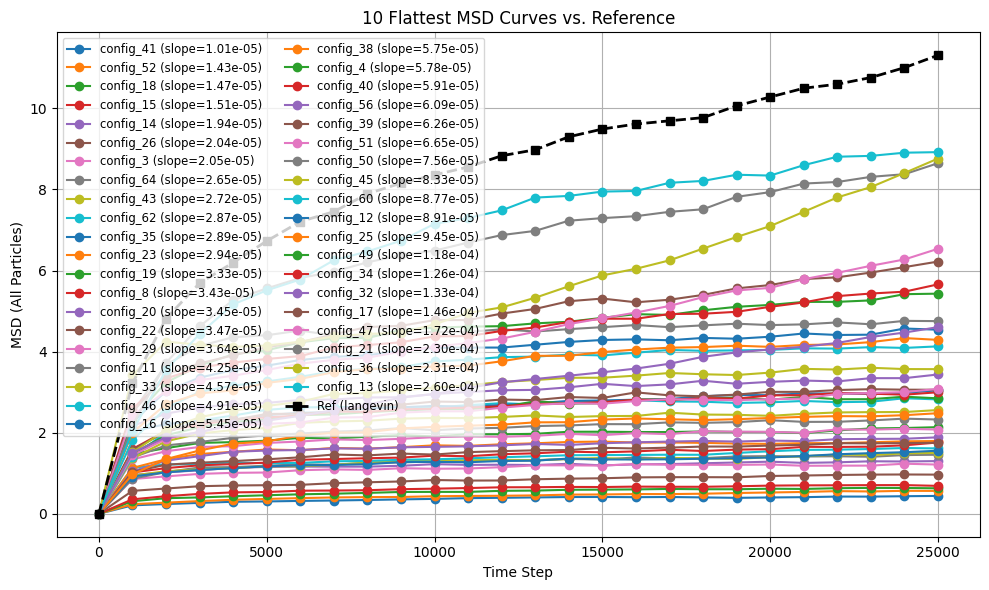

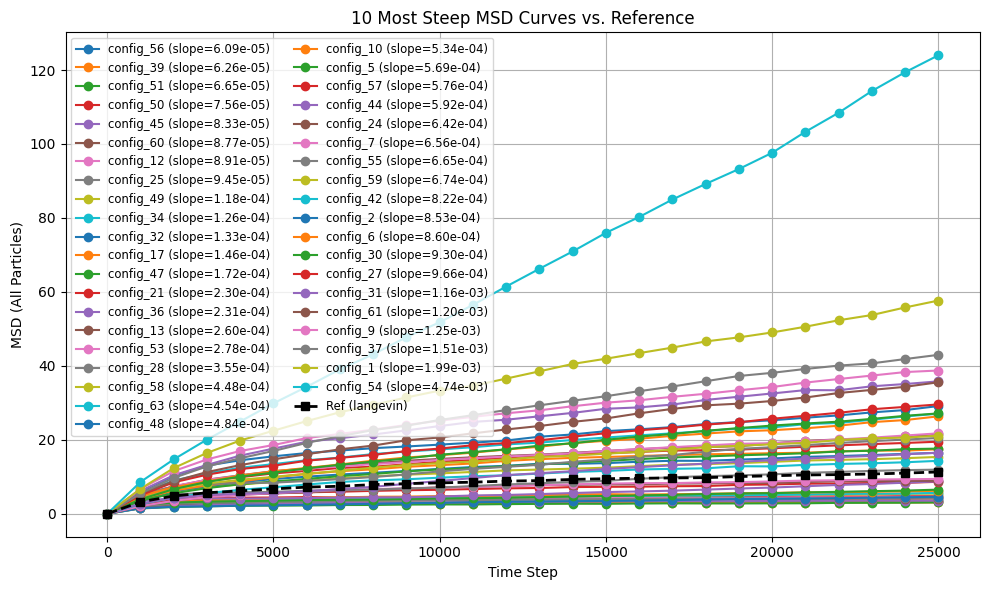

In [40]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load config MSD data
# -------------------------------
base_dir = '.'  # change if your config folders are elsewhere

# Get list of configuration folders (e.g., config_1, config_2, …, config_64)
configs = [d for d in os.listdir(base_dir)
           if d.startswith('config_') and os.path.isdir(os.path.join(base_dir, d))]
configs.sort(key=lambda x: int(x.split('_')[1]))

# Dictionary to store the MSD DataFrame for each config
msd_data_dict = {}
# List to store (config, slope) tuples for the "v_msd_all_val" column
msd_slopes = []

for config in configs:
    msd_file = os.path.join(base_dir, config, 'msd_adapt.out')
    if os.path.isfile(msd_file):
        try:
            # Read the MSD file, skipping comment lines
            data = pd.read_csv(msd_file, comment='#', sep='\s+', header=None)
            # Assign column names (adjust if your file structure is different)
            data.columns = ["TimeStep", "v_msd_all_val", "v_msd_1_val", "v_msd_8_val", "v_msd_9_val"]
            msd_data_dict[config] = data
            # Compute the slope using a simple linear fit (v_msd_all_val vs TimeStep)
            slope, _ = np.polyfit(data["TimeStep"], data["v_msd_all_val"], 1)
            msd_slopes.append((config, slope))
        except Exception as e:
            print(f"Error processing {msd_file}: {e}")

# -------------------------------
# 2. Load reference MSD data from ../langevin/msd_1.out
# -------------------------------
ref_file = os.path.join('..', 'langevin', 'msd_1.out')
if os.path.isfile(ref_file):
    ref_data = pd.read_csv(ref_file, comment='#', sep='\s+', header=None)
    ref_data.columns = ["TimeStep", "v_msd_all_val", "v_msd_1_val", "v_msd_8_val", "v_msd_9_val"]
else:
    ref_data = None
    print("Reference file ../langevin/msd_1.out not found.")

# -------------------------------
# 3. Sort and select 10 flattest and 10 steepest curves
# -------------------------------
msd_slopes_sorted = sorted(msd_slopes, key=lambda x: x[1])
n_select = 40
flattest = msd_slopes_sorted[:n_select]
steepest = msd_slopes_sorted[-n_select:]

# -------------------------------
# 4. Plot 10 Flattest MSD Curves with reference curve
# -------------------------------
plt.figure(figsize=(10, 6))
# Determine common (minimum) length among the flattest curves
min_len_flat = min(len(msd_data_dict[config]) for config, _ in flattest)

for config, slope in flattest:
    data = msd_data_dict[config].iloc[:min_len_flat]
    plt.plot(data["TimeStep"], data["v_msd_all_val"], marker='o',
             label=f"{config} (slope={slope:.2e})")

# Also plot the reference data (if available) trimmed to the same number of steps.
if ref_data is not None:
    ref_subset = ref_data.iloc[:min_len_flat]
    plt.plot(ref_subset["TimeStep"], ref_subset["v_msd_all_val"],
             marker='s', linestyle='--', linewidth=2, color='black', label="Ref (langevin)")

plt.xlabel("Time Step")
plt.ylabel("MSD (All Particles)")
plt.title("10 Flattest MSD Curves vs. Reference")
plt.legend(fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# 5. Plot 10 Most Steep MSD Curves with reference curve
# -------------------------------
plt.figure(figsize=(10, 6))
# Determine common (minimum) length among the steepest curves
min_len_steep = min(len(msd_data_dict[config]) for config, _ in steepest)

for config, slope in steepest:
    data = msd_data_dict[config].iloc[:min_len_steep]
    plt.plot(data["TimeStep"], data["v_msd_all_val"], marker='o',
             label=f"{config} (slope={slope:.2e})")

# Also plot the reference data (if available) trimmed to the same number of steps.
if ref_data is not None:
    ref_subset = ref_data.iloc[:min_len_steep]
    plt.plot(ref_subset["TimeStep"], ref_subset["v_msd_all_val"],
             marker='s', linestyle='--', linewidth=2, color='black', label="Ref (langevin)")

plt.xlabel("Time Step")
plt.ylabel("MSD (All Particles)")
plt.title("10 Most Steep MSD Curves vs. Reference")
plt.legend(fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


<>:79: SyntaxWarning: invalid escape sequence '\s'
<>:79: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1765098/269496004.py:79: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(msd_file, comment='#', sep='\s+', header=None)


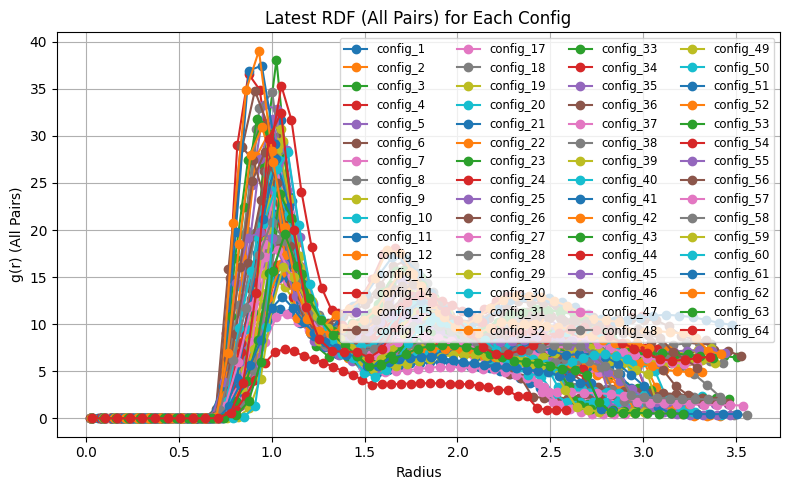

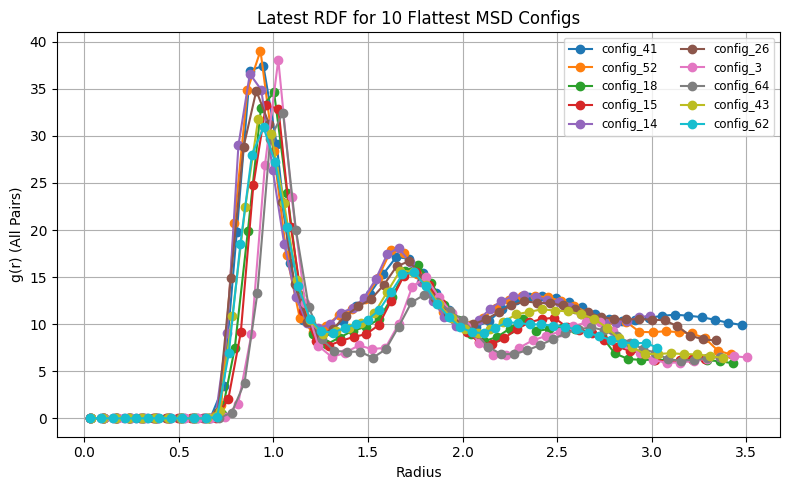

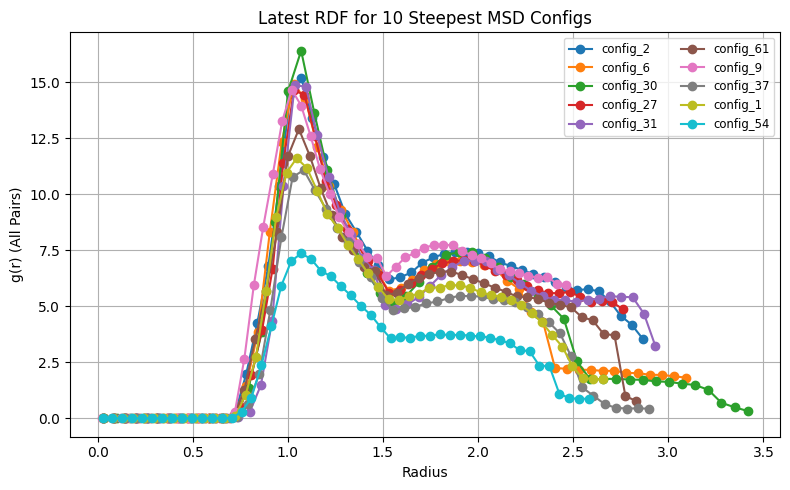

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##########################################################
# 1. Define a function to parse the RDF file into blocks.
##########################################################
def parse_rdf_file(filename):
    """
    Parse the rdf.out file into blocks.
    
    Each block starts with a header line: "TimeStep Number-of-rows"
    followed by that many data rows. Each data row should have 10 numbers:
      [index, radius, g(r1), c(1), g(r2), c(2), g(r3), c(3), g(r4), c(4)]
    
    Returns a dictionary mapping timestep (float) -> pandas DataFrame.
    """
    blocks = {}
    with open(filename, "r") as f:
        lines = f.readlines()
    
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if not line or line.startswith("#"):
            i += 1
            continue
        
        tokens = line.split()
        # Expect header lines with 2 tokens
        if len(tokens) == 2:
            timestep = float(tokens[0])
            nrows = int(tokens[1])
            i += 1  # move to data rows
            block_data = []
            for _ in range(nrows):
                if i >= len(lines):
                    break
                row_line = lines[i].strip()
                if row_line:
                    row_data = [float(tok) for tok in row_line.split()]
                    block_data.append(row_data)
                i += 1
            col_names = ["index", "radius", "g(r1)", "c(1)", 
                         "g(r2)", "c(2)", "g(r3)", "c(3)", 
                         "g(r4)", "c(4)"]
            df_block = pd.DataFrame(block_data, columns=col_names)
            blocks[timestep] = df_block
        else:
            i += 1
    return blocks

##########################################################
# 2. Get the list of config folders.
##########################################################
base_dir = '.'  # Change if your config folders are elsewhere.
configs = [d for d in os.listdir(base_dir)
           if d.startswith('config_') and os.path.isdir(os.path.join(base_dir, d))]
configs.sort(key=lambda x: int(x.split('_')[1]))

##########################################################
# 3. Loop over each config folder to load:
#    (a) The MSD data (to compute slopes)
#    (b) The RDF data (final block only)
##########################################################

# Dictionaries to store data for each config
msd_data_dict = {}  # MSD data for each config.
msd_slopes = []     # List of tuples: (config, slope)
rdf_data_dict = {}  # Final block RDF data for each config.

for config in configs:
    # --- MSD data ---
    msd_file = os.path.join(base_dir, config, 'msd_adapt.out')
    if os.path.isfile(msd_file):
        try:
            # Read the MSD file (skip comment lines)
            data = pd.read_csv(msd_file, comment='#', sep='\s+', header=None)
            # Assign column names (adjust if needed)
            data.columns = ["TimeStep", "v_msd_all_val", "v_msd_1_val", 
                            "v_msd_8_val", "v_msd_9_val"]
            msd_data_dict[config] = data
            # Compute a linear slope for the v_msd_all_val vs TimeStep.
            slope, _ = np.polyfit(data["TimeStep"], data["v_msd_all_val"], 1)
            msd_slopes.append((config, slope))
        except Exception as e:
            print(f"Error processing {msd_file} in {config}: {e}")

    # --- RDF data ---
    rdf_file = os.path.join(base_dir, config, 'rdf_adapt.out')
    if os.path.isfile(rdf_file):
        rdf_blocks = parse_rdf_file(rdf_file)
        if rdf_blocks:
            # Use the final block: largest timestep value.
            latest_ts = max(rdf_blocks.keys())
            rdf_data_dict[config] = rdf_blocks[latest_ts]
        else:
            print(f"No RDF blocks found in {rdf_file} for {config}")

##########################################################
# 4. Plot the full RDF (for all configs) using the final block.
##########################################################
plt.figure(figsize=(8, 5))
for config, df in rdf_data_dict.items():
    plt.plot(df["radius"], df["g(r4)"], marker='o', label=config)
plt.xlabel("Radius")
plt.ylabel("g(r) (All Pairs)")
plt.title("Latest RDF (All Pairs) for Each Config")
plt.legend(fontsize='small', ncol=4)
plt.grid(True)
plt.tight_layout()
plt.show()

##########################################################
# 5. Select 10 flattest and 10 steepest MSD configs.
##########################################################
msd_slopes_sorted = sorted(msd_slopes, key=lambda x: x[1])
n_select = 10
flattest_configs = [config for config, _ in msd_slopes_sorted[:n_select]]
steepest_configs = [config for config, _ in msd_slopes_sorted[-n_select:]]

##########################################################
# 6. Plot RDF for the 10 flattest MSD configs.
##########################################################
plt.figure(figsize=(8, 5))
for config in flattest_configs:
    if config in rdf_data_dict:
        df = rdf_data_dict[config]
        plt.plot(df["radius"], df["g(r4)"], marker='o', label=config)
plt.xlabel("Radius")
plt.ylabel("g(r) (All Pairs)")
plt.title("Latest RDF for 10 Flattest MSD Configs")
plt.legend(fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

##########################################################
# 7. Plot RDF for the 10 steepest MSD configs.
##########################################################
plt.figure(figsize=(8, 5))
for config in steepest_configs:
    if config in rdf_data_dict:
        df = rdf_data_dict[config]
        plt.plot(df["radius"], df["g(r4)"], marker='o', label=config)
plt.xlabel("Radius")
plt.ylabel("g(r) (All Pairs)")
plt.title("Latest RDF for 10 Steepest MSD Configs")
plt.legend(fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


<>:74: SyntaxWarning: invalid escape sequence '\s'
<>:74: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1765098/414582701.py:74: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(msd_file, comment='#', sep='\s+', header=None)


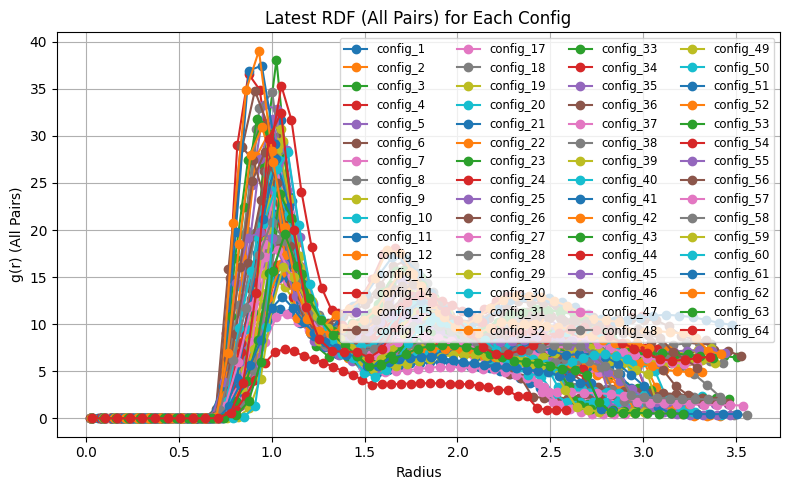

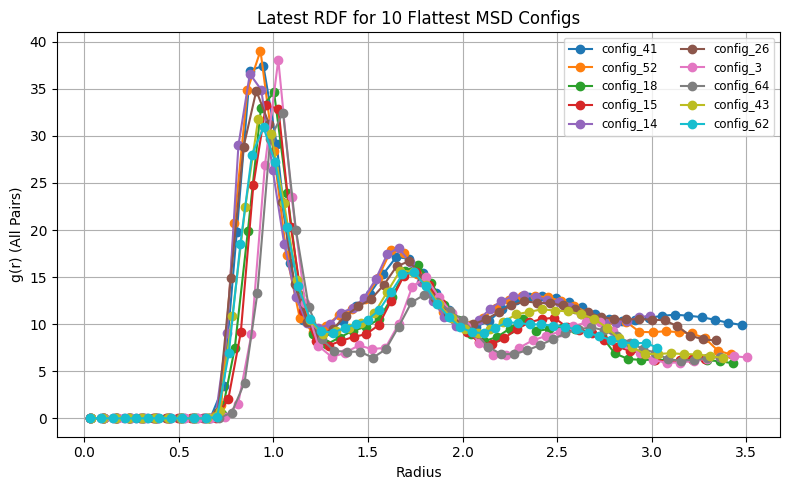

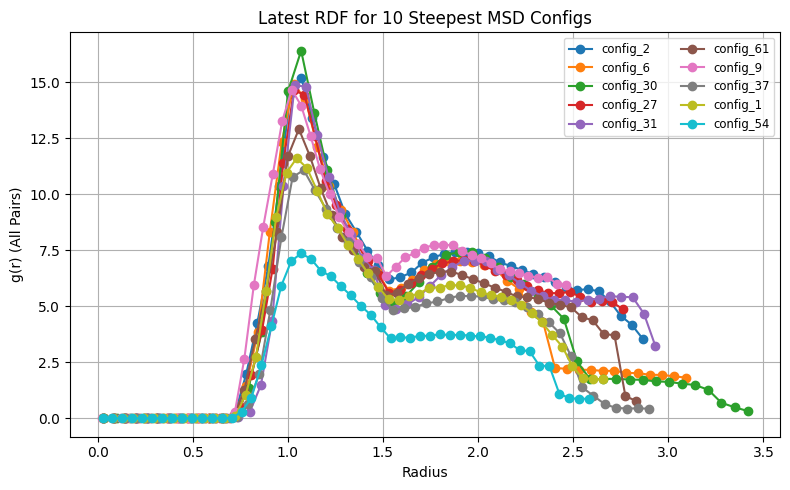

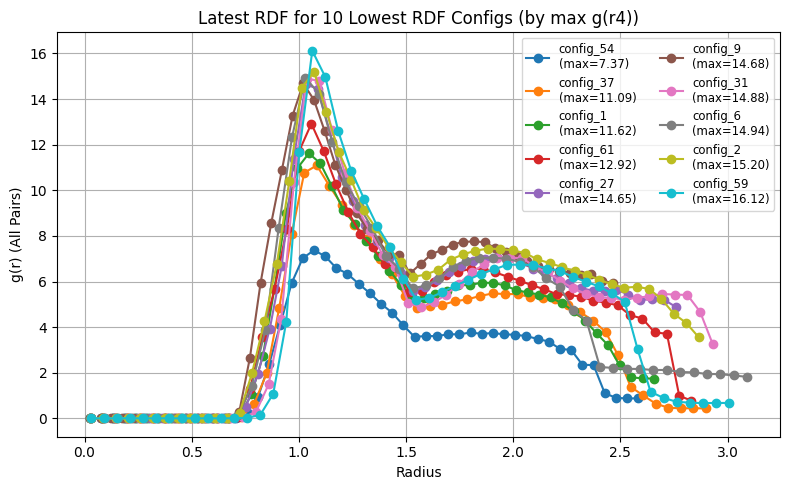

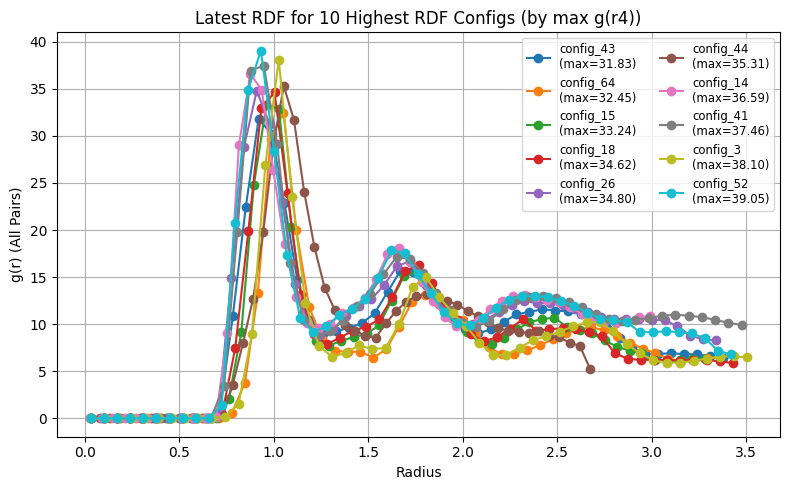

In [41]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##########################################################
# 1. Function to parse an RDF file into blocks.
##########################################################
def parse_rdf_file(filename):
    """
    Parse the rdf.out file into blocks.
    
    Each block starts with a header line: "TimeStep Number-of-rows"
    followed by that many data rows. Each row should have 10 numbers:
      [index, radius, g(r1), c(1), g(r2), c(2), g(r3), c(3), g(r4), c(4)]
    
    Returns a dictionary mapping timestep (float) -> pandas DataFrame.
    """
    blocks = {}
    with open(filename, "r") as f:
        lines = f.readlines()
    
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if not line or line.startswith("#"):
            i += 1
            continue
        
        tokens = line.split()
        # Expect header lines with 2 tokens: timestep and number-of-rows.
        if len(tokens) == 2:
            timestep = float(tokens[0])
            nrows = int(tokens[1])
            i += 1  # move to data rows
            block_data = []
            for _ in range(nrows):
                if i >= len(lines):
                    break
                row_line = lines[i].strip()
                if row_line:
                    row_data = [float(tok) for tok in row_line.split()]
                    block_data.append(row_data)
                i += 1
            col_names = ["index", "radius", "g(r1)", "c(1)", 
                         "g(r2)", "c(2)", "g(r3)", "c(3)", 
                         "g(r4)", "c(4)"]
            df_block = pd.DataFrame(block_data, columns=col_names)
            blocks[timestep] = df_block
        else:
            i += 1
    return blocks

##########################################################
# 2. Get list of configuration folders.
##########################################################
base_dir = '.'  # Adjust if your config folders are in a different directory.
configs = [d for d in os.listdir(base_dir)
           if d.startswith('config_') and os.path.isdir(os.path.join(base_dir, d))]
configs.sort(key=lambda x: int(x.split('_')[1]))

##########################################################
# 3. Loop over each config to load MSD and RDF data.
##########################################################
msd_data_dict = {}  # MSD data for each config.
msd_slopes = []     # List of tuples: (config, slope)
rdf_data_dict = {}  # Final block RDF data for each config.

for config in configs:
    # --- Load MSD data ---
    msd_file = os.path.join(base_dir, config, 'msd_adapt.out')
    if os.path.isfile(msd_file):
        try:
            data = pd.read_csv(msd_file, comment='#', sep='\s+', header=None)
            data.columns = ["TimeStep", "v_msd_all_val", "v_msd_1_val", 
                            "v_msd_8_val", "v_msd_9_val"]
            msd_data_dict[config] = data
            # Compute a linear slope for v_msd_all_val vs TimeStep.
            slope, _ = np.polyfit(data["TimeStep"], data["v_msd_all_val"], 1)
            msd_slopes.append((config, slope))
        except Exception as e:
            print(f"Error processing {msd_file} in {config}: {e}")
    
    # --- Load RDF data ---
    rdf_file = os.path.join(base_dir, config, 'rdf_adapt.out')
    if os.path.isfile(rdf_file):
        rdf_blocks = parse_rdf_file(rdf_file)
        if rdf_blocks:
            # Use the final (latest) block: largest timestep.
            latest_ts = max(rdf_blocks.keys())
            rdf_data_dict[config] = rdf_blocks[latest_ts]
        else:
            print(f"No RDF blocks found in {rdf_file} for {config}")

##########################################################
# 4. Compute an RDF measure for each config.
#    (Here we use the maximum of g(r4) as a simple metric.)
##########################################################
rdf_extrema = []  # List of tuples: (config, max_g_r4)
for config, df in rdf_data_dict.items():
    max_val = df["g(r4)"].max()
    rdf_extrema.append((config, max_val))

##########################################################
# 5. Plot RDF curves for all configs.
##########################################################
plt.figure(figsize=(8, 5))
for config, df in rdf_data_dict.items():
    plt.plot(df["radius"], df["g(r4)"], marker='o', label=config)
plt.xlabel("Radius")
plt.ylabel("g(r) (All Pairs)")
plt.title("Latest RDF (All Pairs) for Each Config")
plt.legend(fontsize='small', ncol=4)
plt.grid(True)
plt.tight_layout()
plt.show()

##########################################################
# 6. Select 10 flattest and 10 steepest MSD configs.
##########################################################
msd_slopes_sorted = sorted(msd_slopes, key=lambda x: x[1])
n_select = 10
flattest_configs = [config for config, _ in msd_slopes_sorted[:n_select]]
steepest_configs = [config for config, _ in msd_slopes_sorted[-n_select:]]

##########################################################
# 7. Plot RDF for the 10 flattest MSD configs.
##########################################################
plt.figure(figsize=(8, 5))
for config in flattest_configs:
    if config in rdf_data_dict:
        df = rdf_data_dict[config]
        plt.plot(df["radius"], df["g(r4)"], marker='o', label=config)
plt.xlabel("Radius")
plt.ylabel("g(r) (All Pairs)")
plt.title("Latest RDF for 10 Flattest MSD Configs")
plt.legend(fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

##########################################################
# 8. Plot RDF for the 10 steepest MSD configs.
##########################################################
plt.figure(figsize=(8, 5))
for config in steepest_configs:
    if config in rdf_data_dict:
        df = rdf_data_dict[config]
        plt.plot(df["radius"], df["g(r4)"], marker='o', label=config)
plt.xlabel("Radius")
plt.ylabel("g(r) (All Pairs)")
plt.title("Latest RDF for 10 Steepest MSD Configs")
plt.legend(fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

##########################################################
# 9. Select 10 configs with the lowest and highest RDF measures.
#    (Here, lowest/highest maximum g(r4).)
##########################################################
rdf_extrema_sorted = sorted(rdf_extrema, key=lambda x: x[1])
lowest_rdf_configs = [config for config, _ in rdf_extrema_sorted[:n_select]]
highest_rdf_configs = [config for config, _ in rdf_extrema_sorted[-n_select:]]

##########################################################
# 10. Plot RDF for the 10 configs with the lowest RDF values.
##########################################################
plt.figure(figsize=(8, 5))
for config in lowest_rdf_configs:
    if config in rdf_data_dict:
        df = rdf_data_dict[config]
        plt.plot(df["radius"], df["g(r4)"], marker='o', label=f"{config}\n(max={df['g(r4)'].max():.2f})")
plt.xlabel("Radius")
plt.ylabel("g(r) (All Pairs)")
plt.title("Latest RDF for 10 Lowest RDF Configs (by max g(r4))")
plt.legend(fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

##########################################################
# 11. Plot RDF for the 10 configs with the highest RDF values.
##########################################################
plt.figure(figsize=(8, 5))
for config in highest_rdf_configs:
    if config in rdf_data_dict:
        df = rdf_data_dict[config]
        plt.plot(df["radius"], df["g(r4)"], marker='o', label=f"{config}\n(max={df['g(r4)'].max():.2f})")
plt.xlabel("Radius")
plt.ylabel("g(r) (All Pairs)")
plt.title("Latest RDF for 10 Highest RDF Configs (by max g(r4))")
plt.legend(fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


<>:74: SyntaxWarning: invalid escape sequence '\s'
<>:74: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1765098/1214215071.py:74: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(msd_file, comment='#', sep='\s+', header=None)


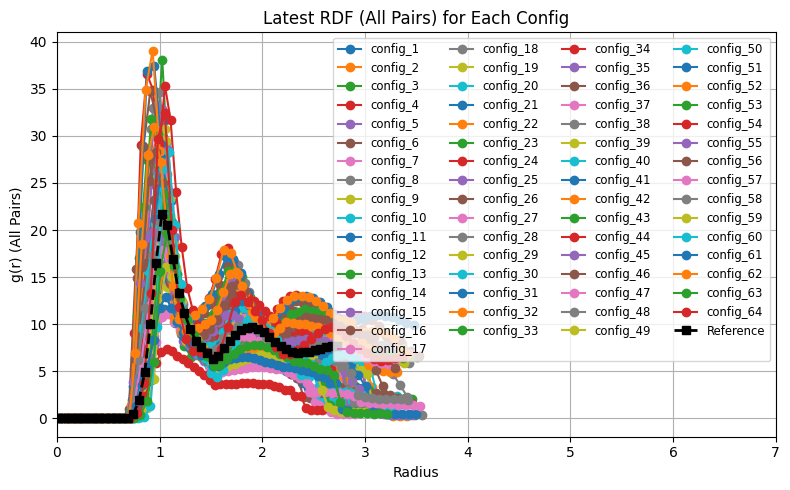

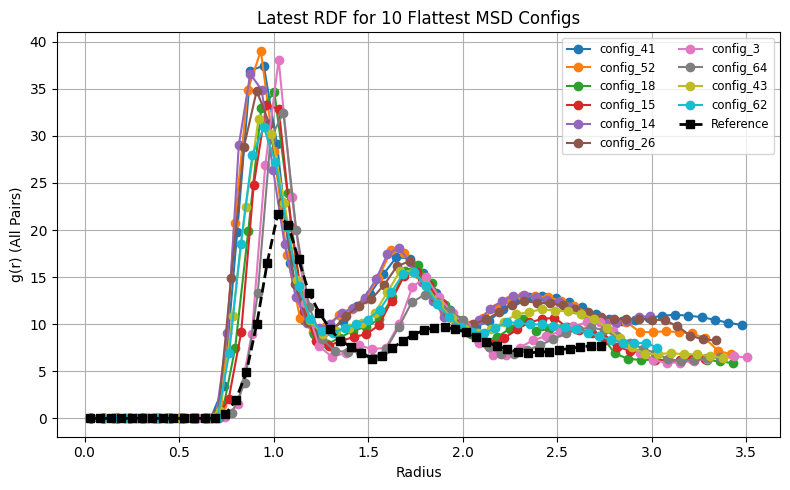

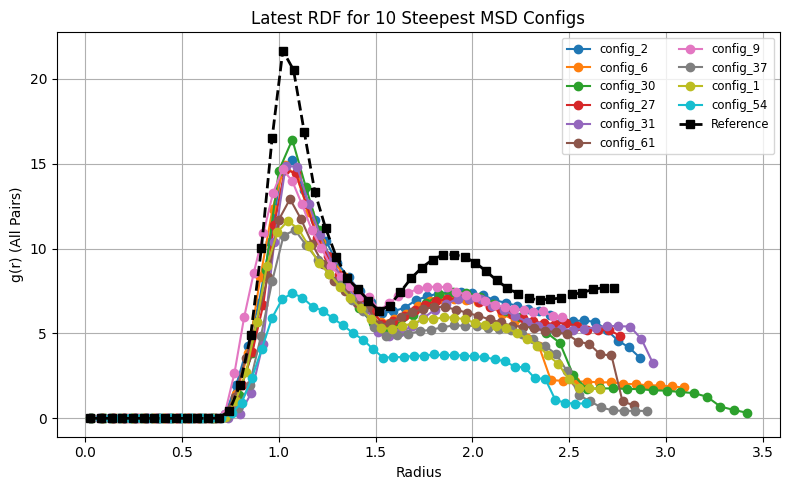

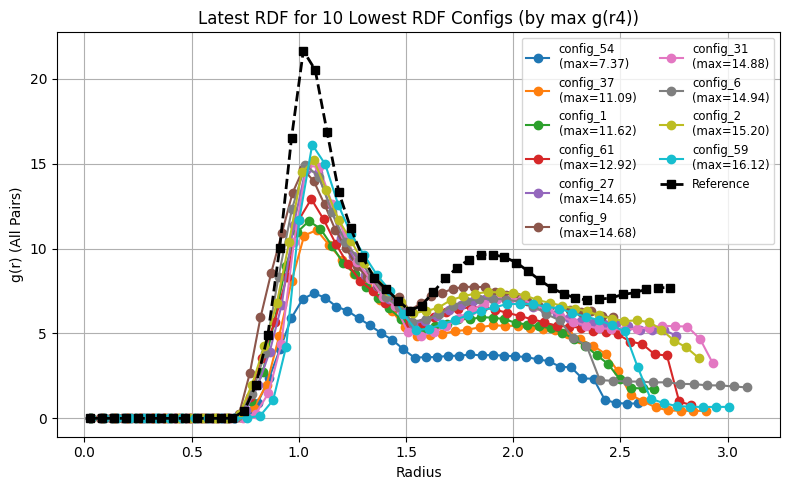

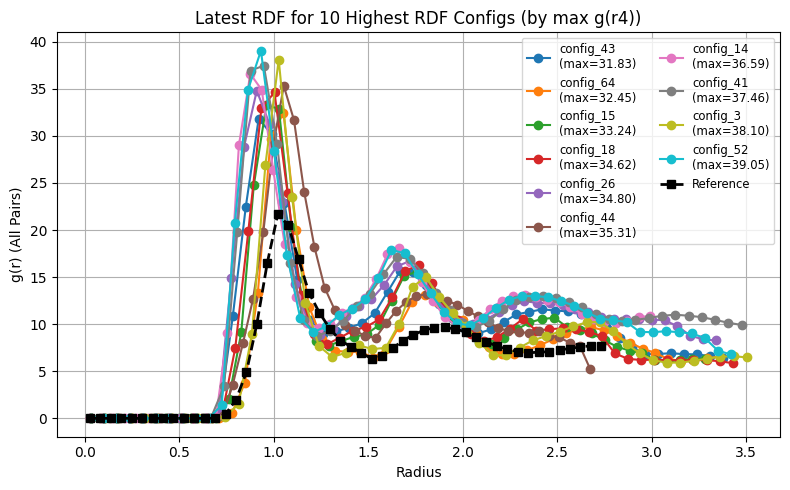

In [50]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##########################################################
# 1. Function to parse an RDF file into blocks.
##########################################################
def parse_rdf_file(filename):
    """
    Parse the rdf.out file into blocks.
    
    Each block starts with a header line: "TimeStep Number-of-rows"
    followed by that many data rows. Each row should have 10 numbers:
      [index, radius, g(r1), c(1), g(r2), c(2), g(r3), c(3), g(r4), c(4)]
    
    Returns a dictionary mapping timestep (float) -> pandas DataFrame.
    """
    blocks = {}
    with open(filename, "r") as f:
        lines = f.readlines()
    
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if not line or line.startswith("#"):
            i += 1
            continue
        
        tokens = line.split()
        # Expect header lines with 2 tokens: timestep and number-of-rows.
        if len(tokens) == 2:
            timestep = float(tokens[0])
            nrows = int(tokens[1])
            i += 1  # move to data rows
            block_data = []
            for _ in range(nrows):
                if i >= len(lines):
                    break
                row_line = lines[i].strip()
                if row_line:
                    row_data = [float(tok) for tok in row_line.split()]
                    block_data.append(row_data)
                i += 1
            col_names = ["index", "radius", "g(r1)", "c(1)", 
                         "g(r2)", "c(2)", "g(r3)", "c(3)", 
                         "g(r4)", "c(4)"]
            df_block = pd.DataFrame(block_data, columns=col_names)
            blocks[timestep] = df_block
        else:
            i += 1
    return blocks

##########################################################
# 2. Get list of configuration folders.
##########################################################
base_dir = '.'  # Adjust if your config folders are in a different directory.
configs = [d for d in os.listdir(base_dir)
           if d.startswith('config_') and os.path.isdir(os.path.join(base_dir, d))]
configs.sort(key=lambda x: int(x.split('_')[1]))

##########################################################
# 3. Loop over each config to load MSD and RDF data.
##########################################################
msd_data_dict = {}  # MSD data for each config.
msd_slopes = []     # List of tuples: (config, slope)
rdf_data_dict = {}  # Final block RDF data for each config.

for config in configs:
    # --- Load MSD data ---
    msd_file = os.path.join(base_dir, config, 'msd_adapt.out')
    if os.path.isfile(msd_file):
        try:
            data = pd.read_csv(msd_file, comment='#', sep='\s+', header=None)
            data.columns = ["TimeStep", "v_msd_all_val", "v_msd_1_val", 
                            "v_msd_8_val", "v_msd_9_val"]
            msd_data_dict[config] = data
            # Compute a linear slope for v_msd_all_val vs TimeStep.
            slope, _ = np.polyfit(data["TimeStep"], data["v_msd_all_val"], 1)
            msd_slopes.append((config, slope))
        except Exception as e:
            print(f"Error processing {msd_file} in {config}: {e}")
    
    # --- Load RDF data ---
    rdf_file = os.path.join(base_dir, config, 'rdf_adapt.out')
    if os.path.isfile(rdf_file):
        rdf_blocks = parse_rdf_file(rdf_file)
        if rdf_blocks:
            # Use the final (latest) block: largest timestep.
            latest_ts = max(rdf_blocks.keys())
            rdf_data_dict[config] = rdf_blocks[latest_ts]
        else:
            print(f"No RDF blocks found in {rdf_file} for {config}")

##########################################################
# 4. Load the reference RDF file (if available).
#    Here we assume it's located at ../langevin/rdf_adapt.out.
##########################################################
ref_rdf_file = os.path.join("..", "langevin", "rdf_1.out")
ref_df = None
if os.path.isfile(ref_rdf_file):
    ref_blocks = parse_rdf_file(ref_rdf_file)
    if ref_blocks:
        ref_latest_ts = max(ref_blocks.keys())
        ref_df = ref_blocks[ref_latest_ts]
    else:
        print("No RDF blocks found in the reference file.")
else:
    print("Reference RDF file not found.")

##########################################################
# 5. Compute an RDF measure for each config.
#    (Here we use the maximum of g(r4) as a simple metric.)
##########################################################
rdf_extrema = []  # List of tuples: (config, max_g_r4)
for config, df in rdf_data_dict.items():
    max_val = df["g(r4)"].max()
    rdf_extrema.append((config, max_val))

##########################################################
# 6. Plot RDF curves for all configs (plus reference if available).
##########################################################
plt.figure(figsize=(8, 5))
for config, df in rdf_data_dict.items():
    plt.plot(df["radius"], df["g(r4)"], marker='o', label=config)
if ref_df is not None:
    plt.plot(ref_df["radius"], ref_df["g(r4)"], marker='s', linestyle='--', 
             linewidth=2, color='black', label="Reference")
plt.xlabel("Radius")
plt.ylabel("g(r) (All Pairs)")
plt.title("Latest RDF (All Pairs) for Each Config")
plt.legend(fontsize='small', ncol=4)
plt.grid(True)
plt.xlim(0,7)
plt.tight_layout()
plt.show()

##########################################################
# 7. Select 10 flattest and 10 steepest MSD configs.
##########################################################
msd_slopes_sorted = sorted(msd_slopes, key=lambda x: x[1])
n_select = 10
flattest_configs = [config for config, _ in msd_slopes_sorted[:n_select]]
steepest_configs = [config for config, _ in msd_slopes_sorted[-n_select:]]

##########################################################
# 8. Plot RDF for the 10 flattest MSD configs (plus reference if available).
##########################################################
plt.figure(figsize=(8, 5))
for config in flattest_configs:
    if config in rdf_data_dict:
        df = rdf_data_dict[config]
        plt.plot(df["radius"], df["g(r4)"], marker='o', label=config)
if ref_df is not None:
    plt.plot(ref_df["radius"], ref_df["g(r4)"], marker='s', linestyle='--', 
             linewidth=2, color='black', label="Reference")
plt.xlabel("Radius")
plt.ylabel("g(r) (All Pairs)")
plt.title("Latest RDF for 10 Flattest MSD Configs")
plt.legend(fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

##########################################################
# 9. Plot RDF for the 10 steepest MSD configs (plus reference if available).
##########################################################
plt.figure(figsize=(8, 5))
for config in steepest_configs:
    if config in rdf_data_dict:
        df = rdf_data_dict[config]
        plt.plot(df["radius"], df["g(r4)"], marker='o', label=config)
if ref_df is not None:
    plt.plot(ref_df["radius"], ref_df["g(r4)"], marker='s', linestyle='--', 
             linewidth=2, color='black', label="Reference")
plt.xlabel("Radius")
plt.ylabel("g(r) (All Pairs)")
plt.title("Latest RDF for 10 Steepest MSD Configs")
plt.legend(fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

##########################################################
# 10. Select 10 configs with the lowest and highest RDF measures.
#     (Here, lowest/highest maximum g(r4).)
##########################################################
rdf_extrema_sorted = sorted(rdf_extrema, key=lambda x: x[1])
lowest_rdf_configs = [config for config, _ in rdf_extrema_sorted[:n_select]]
highest_rdf_configs = [config for config, _ in rdf_extrema_sorted[-n_select:]]

##########################################################
# 11. Plot RDF for the 10 configs with the lowest RDF values (plus reference).
##########################################################
plt.figure(figsize=(8, 5))
for config in lowest_rdf_configs:
    if config in rdf_data_dict:
        df = rdf_data_dict[config]
        plt.plot(df["radius"], df["g(r4)"], marker='o', 
                 label=f"{config}\n(max={df['g(r4)'].max():.2f})")
if ref_df is not None:
    plt.plot(ref_df["radius"], ref_df["g(r4)"], marker='s', linestyle='--', 
             linewidth=2, color='black', label="Reference")
plt.xlabel("Radius")
plt.ylabel("g(r) (All Pairs)")
plt.title("Latest RDF for 10 Lowest RDF Configs (by max g(r4))")
plt.legend(fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

##########################################################
# 12. Plot RDF for the 10 configs with the highest RDF values (plus reference).
##########################################################
plt.figure(figsize=(8, 5))
for config in highest_rdf_configs:
    if config in rdf_data_dict:
        df = rdf_data_dict[config]
        plt.plot(df["radius"], df["g(r4)"], marker='o', 
                 label=f"{config}\n(max={df['g(r4)'].max():.2f})")
if ref_df is not None:
    plt.plot(ref_df["radius"], ref_df["g(r4)"], marker='s', linestyle='--', 
             linewidth=2, color='black', label="Reference")
plt.xlabel("Radius")
plt.ylabel("g(r) (All Pairs)")
plt.title("Latest RDF for 10 Highest RDF Configs (by max g(r4))")
plt.legend(fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


In [71]:
import os
import numpy as np
import pandas as pd

# --- 1. Compute MSD slopes for each config ---
base_dir = '.'  # Adjust if your config folders are elsewhere.

# Get list of configuration folders (e.g., config_1, config_2, ..., config_64)
configs = [d for d in os.listdir(base_dir)
           if d.startswith('config_') and os.path.isdir(os.path.join(base_dir, d))]
configs.sort(key=lambda x: int(x.split('_')[1]))

msd_slopes = []  # List to store tuples: (config, slope)

for config in configs:
    msd_file = os.path.join(base_dir, config, 'msd_adapt.out')
    if os.path.isfile(msd_file):
        try:
            # Read the MSD file, skipping comment lines
            data = pd.read_csv(msd_file, comment='#', sep='\s+', header=None)
            # Assign column names (adjust as necessary)
            data.columns = ["TimeStep", "v_msd_all_val", "v_msd_1_val", "v_msd_8_val", "v_msd_9_val"]
            # Compute a simple linear fit (slope of v_msd_all_val vs TimeStep)
            slope, _ = np.polyfit(data["TimeStep"], data["v_msd_all_val"], 1)
            msd_slopes.append((config, slope))
        except Exception as e:
            print(f"Error processing {msd_file} for {config}: {e}")

# Create a DataFrame from the computed slopes.
msd_slopes_df = pd.DataFrame(msd_slopes, columns=["config", "msd_slope"])

# Sort the DataFrame from steepest to flattest (steepest = highest slope)
msd_slopes_df.sort_values("msd_slope", ascending=False, inplace=True)

# --- 2. Load the parameter_samples.csv file ---
param_df = pd.read_csv("parameter_samples.csv")

# Since the CSV doesn't have a "config" column, assign one assuming row 1 means config_1, row 2 means config_2, etc.
param_df['config'] = "config_" + (param_df.index + 1).astype(str)

# --- 3. Merge the MSD slopes with the 'status' column from the CSV ---
merged_df = msd_slopes_df.merge(param_df[["config", "status"]], on="config", how="left")

# Optionally, set the config as the index.
merged_df.set_index("config", inplace=True)

# Display the resulting DataFrame.
merged_df


<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1765098/1314740324.py:20: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(msd_file, comment='#', sep='\s+', header=None)


msd_slope           status
config                               
config_54   0.004738         unstable
config_1    0.001994         unstable
config_37   0.001512         unstable
config_9    0.001248         unstable
config_61   0.001200         unstable
...              ...              ...
config_14   0.000019           stable
config_15   0.000015           stable
config_18   0.000015   stable #solid?
config_52   0.000014   stable #solid?
config_41   0.000010           stable

[64 rows x 2 columns]

In [72]:
import numpy as np
import pandas as pd

# Helper function to compute the height of the first RDF peak.
def get_first_rdf_peak_height(rdf_df, r_min=0.2, r_max=1.2):
    """
    Given an RDF DataFrame with columns "radius" and "g(r4)",
    returns the maximum of g(r4) within the interval [r_min, r_max].
    Adjust r_min and r_max to capture the first RDF peak.
    """
    subset = rdf_df[(rdf_df["radius"] >= r_min) & (rdf_df["radius"] <= r_max)]
    if subset.empty:
        return None
    return subset["g(r4)"].max()

# --- Append a new column for the MSD slope computed on the last 15k steps.
msd_slope_last15k_dict = {}
for config in merged_df.index:
    if config in msd_data_dict:
        msd_df = msd_data_dict[config]
        # Use the last 15,000 rows if available; otherwise, use all rows.
        if len(msd_df) >= 15000:
            subset = msd_df.iloc[-15000:]
        else:
            subset = msd_df
        try:
            slope_last15k, _ = np.polyfit(subset["TimeStep"], subset["v_msd_all_val"], 1)
            msd_slope_last15k_dict[config] = slope_last15k
        except Exception as e:
            print(f"Error computing last15k slope for {config}: {e}")
            msd_slope_last15k_dict[config] = None
    else:
        msd_slope_last15k_dict[config] = None

# Convert the dictionary to a Series and assign as a new column.
merged_df["msd_slope_last15k"] = pd.Series(msd_slope_last15k_dict)

# --- Append a new column for the RDF first peak height.
rdf_peak_dict = {}
for config in merged_df.index:
    if config in rdf_data_dict:
        rdf_df = rdf_data_dict[config]
        peak_val = get_first_rdf_peak_height(rdf_df, r_min=0.2, r_max=1.2)
        rdf_peak_dict[config] = peak_val
    else:
        rdf_peak_dict[config] = None

merged_df["rdf_first_peak"] = pd.Series(rdf_peak_dict)

# Display the updated merged_df
print("Updated merged_df:")
merged_df


Updated merged_df:


msd_slope           status  msd_slope_last15k  rdf_first_peak
config                                                                  
config_54   0.004738         unstable           0.004738          7.3697
config_1    0.001994         unstable           0.001994         11.6219
config_37   0.001512         unstable           0.001512         11.0912
config_9    0.001248         unstable           0.001248         14.6832
config_61   0.001200         unstable           0.001200         12.9211
...              ...              ...                ...             ...
config_14   0.000019           stable           0.000019         36.5921
config_15   0.000015           stable           0.000015         33.2419
config_18   0.000015   stable #solid?           0.000015         34.6212
config_52   0.000014   stable #solid?           0.000014         39.0511
config_41   0.000010           stable           0.000010         37.4606

[64 rows x 4 columns]

In [73]:
merged_df[0:60]

msd_slope             status  msd_slope_last15k  rdf_first_peak
config                                                                    
config_54   0.004738           unstable           0.004738          7.3697
config_1    0.001994           unstable           0.001994         11.6219
config_37   0.001512           unstable           0.001512         11.0912
config_9    0.001248           unstable           0.001248         14.6832
config_61   0.001200           unstable           0.001200         12.9211
config_31   0.001161           unstable           0.001161         14.8802
config_27   0.000966           unstable           0.000966         14.6509
config_30   0.000930           unstable           0.000930         16.4185
config_6    0.000860           unstable           0.000860         14.9371
config_2    0.000853           unstable           0.000853         15.1974
config_42   0.000822           unstable           0.000822         16.4075
config_59   0.000674           unstable           0.000674         16.1198
config_55   0.000665           unstable           0.000665         19.7545
config_7    0.000656             stable           0.000656         16.3386
config_24   0.000642             stable           0.000642         16.6782
config_44   0.000592             stable           0.000592         35.3096
config_57   0.000576             stable           0.000576         17.9255
config_5    0.000569             stable           0.000569         18.5771
config_10   0.000534             stable           0.000534         21.8229
config_48   0.000484   stable #probably           0.000484         19.0820
config_63   0.000454    stable #budding           0.000454         19.5811
config_58   0.000448             stable           0.000448         20.9086
config_28   0.000355             stable           0.000355         21.7491
config_53   0.000278             stable           0.000278         23.8745
config_13   0.000260             stable           0.000260         22.2365
config_36   0.000231           unstable           0.000231         28.9399
config_21   0.000230             stable           0.000230         21.6784
config_47   0.000172   stable #probably           0.000172         26.0779
config_17   0.000146             stable           0.000146         23.4611
config_32   0.000133             stable           0.000133         28.3212
config_34   0.000126             stable           0.000126         25.3413
config_49   0.000118             stable           0.000118         25.0040
config_25   0.000095     stable #solid?           0.000095         26.6453
config_12   0.000089             stable           0.000089         25.9987
config_60   0.000088             stable           0.000088         28.2505
config_45   0.000083             stable           0.000083         28.5052
config_50   0.000076             stable           0.000076         24.4838
config_51   0.000067             stable           0.000067         27.5369
config_39   0.000063     stable #solid?           0.000063         28.7660
config_56   0.000061             stable           0.000061         28.2806
config_40   0.000059             stable           0.000059         27.4413
config_4    0.000058             stable           0.000058         28.1179
config_38   0.000058             stable           0.000058         28.4776
config_16   0.000054             stable           0.000054         29.8753
config_46   0.000049             stable           0.000049         27.7204
config_33   0.000046             stable           0.000046         28.0840
config_11   0.000043             stable           0.000043         31.6720
config_29   0.000036             stable           0.000036         30.0178
config_22   0.000035             stable           0.000035         30.0930
config_20   0.000034     stable #solid?           0.000034         29.2998
config_8    0.000034             stable           0.000034         31.3989
config_19   0.000033     stable #sol

msd_slope is equal to msd_slope_last15k for all configurations.


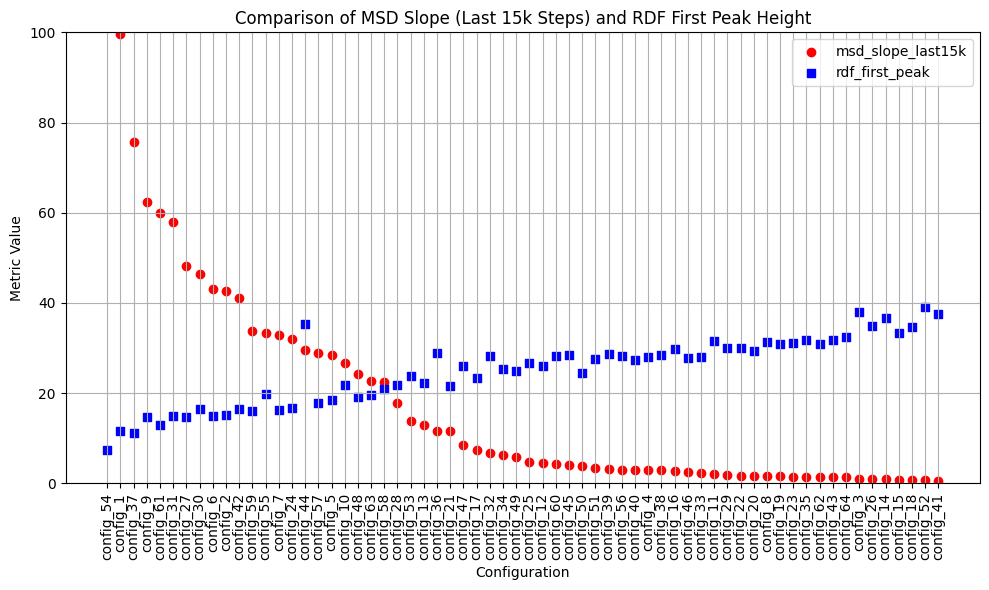

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming merged_df already exists with index like "config_1", "config_2", etc.
# and columns: ['msd_slope', 'status'].
# Also assuming that you have already added the columns "msd_slope_last15k" and "rdf_first_peak" 
# to merged_df using previous code.

# --- Check if msd_slope is equal to msd_slope_last15k ---
# Using np.allclose to compare with a small tolerance
if np.allclose(merged_df['msd_slope'].values, merged_df['msd_slope_last15k'].values, rtol=1e-8, atol=1e-8):
    print("msd_slope is equal to msd_slope_last15k for all configurations.")
else:
    print("msd_slope is NOT equal to msd_slope_last15k for some configurations.")
    diff = merged_df['msd_slope'] - merged_df['msd_slope_last15k']
    print("Differences:\n", diff)

# --- Plot msd_slope_last15k and rdf_first_peak in one plot ---
# We'll use the configuration index (from merged_df.index) as the x-axis.
configs = merged_df.index.tolist()
x = np.arange(len(configs))

plt.figure(figsize=(10, 6))
# Plot the msd_slope_last15k (red circles)
plt.scatter(x, merged_df['msd_slope_last15k']*50000, color='red', marker='o', label='msd_slope_last15k')
# Plot the rdf_first_peak (blue squares)
plt.scatter(x, merged_df['rdf_first_peak'], color='blue', marker='s', label='rdf_first_peak')

# Annotate the x-axis with configuration names.
plt.xticks(x, configs, rotation=90)
plt.xlabel("Configuration")
plt.ylabel("Metric Value")
plt.title("Comparison of MSD Slope (Last 15k Steps) and RDF First Peak Height")
plt.legend()
plt.ylim(0,100)
plt.grid(True)
plt.tight_layout()
plt.show()



msd_slope is equal to msd_slope_last15k for all configurations.


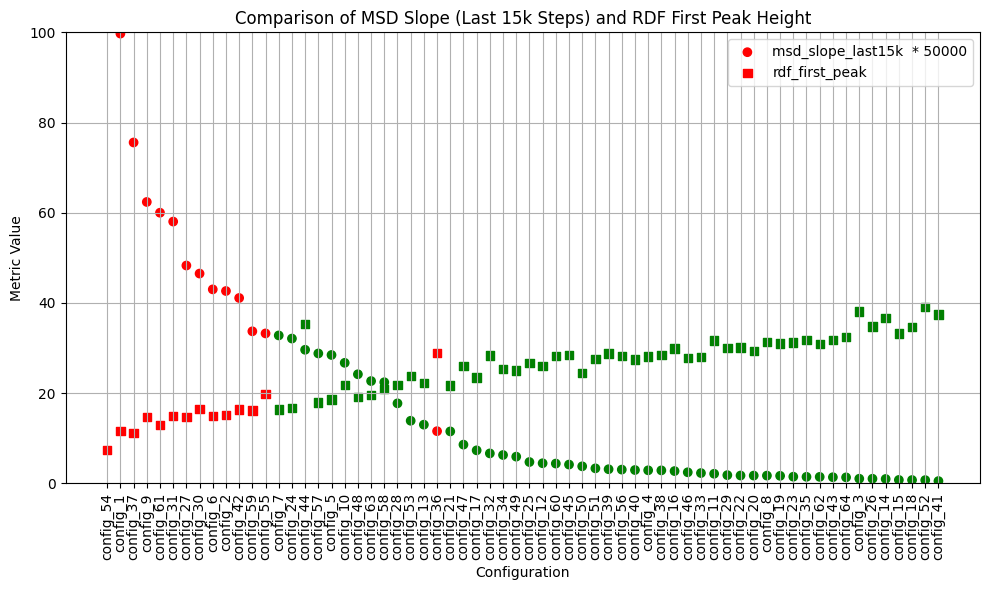

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Check if msd_slope equals msd_slope_last15k ---
if np.allclose(merged_df['msd_slope'].values, merged_df['msd_slope_last15k'].values, rtol=1e-8, atol=1e-8):
    print("msd_slope is equal to msd_slope_last15k for all configurations.")
else:
    print("msd_slope is NOT equal to msd_slope_last15k for some configurations.")
    diff = merged_df['msd_slope'] - merged_df['msd_slope_last15k']
    print("Differences:\n", diff)

# --- Plot msd_slope_last15k and rdf_first_peak in one plot ---

# Get configuration names from the index of merged_df.
configs = merged_df.index.tolist()
x = np.arange(len(configs))

# Create a color list based on status: red if 'unstable', green otherwise.
colors = ['red' if status == ' unstable' else 'green' for status in merged_df['status']]

plt.figure(figsize=(10, 6))
# Plot msd_slope_last15k (scaled by 50,000) with corresponding colors.
plt.scatter(x, merged_df['msd_slope_last15k'] * 50000, c=colors, marker='o', label='msd_slope_last15k  * 50000')
# Plot rdf_first_peak with the same color coding.
plt.scatter(x, merged_df['rdf_first_peak'], c=colors, marker='s', label='rdf_first_peak')

# Annotate the x-axis with configuration names.
plt.xticks(x, configs, rotation=90)
plt.xlabel("Configuration")
plt.ylabel("Metric Value")
plt.title("Comparison of MSD Slope (Last 15k Steps) and RDF First Peak Height")
plt.legend()
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
merged_df

NameError: name 'merged_df' is not defined

In [126]:
params = pd.read_csv("parameter_samples.csv")

k_bend_saturated  k_bend_unsaturated  k_bend_cholesterol  w_c_default  \
0          11.422428            1.620071            7.106316     0.959733   
1          10.133905            5.205917            3.878774     1.416595   
2           7.552117            8.788101            8.498987     2.416922   
3           4.383901            8.083707            6.136164     1.482366   
4          12.375734            1.899940           10.810740     1.592721   
..               ...                 ...                 ...          ...   
59         17.583064            4.764086           11.931013     1.568790   
60          8.586510            6.490490           11.279667     1.226878   
61          4.466159            3.922506            9.886832     1.937024   
62          7.594832            3.039634            1.783131     1.215145   
63         19.481477            4.242350            7.844934     2.104338   

     w_c_U-S   w_c_U-C   w_c_C-S  Temperature  outer_typeOne  outer_typeTwo  \
0   1.367492  1.543889  1.674346     1.344913       0.413212       0.148187   
1   1.771953  1.279933  0.995776     1.504326       0.123749       0.610003   
2   2.381959  1.541134  1.480404     1.028319       0.713556       0.190624   
3   1.431776  1.878525  2.113463     0.970237       0.374749       0.336342   
4   1.216442  0.839303  0.948605     1.316478       0.793382       0.165165   
..       ...       ...       ...          ...            ...            ...   
59  0.807284  1.929573  0.841134     0.807790       0.625053       0.364219   
60  0.909134  0.934122  1.850319     1.327542       0.699053       0.206002   
61  1.936466  0.877510  1.623155     1.011451       0.199589       0.257803   
62  0.974143  2.117305  2.236298     0.952376       0.538713       0.416038   
63  2.080820  1.638443  2.382112     0.977157       0.618821       0.230640   

    inner_typeThr  inner_typeFour            status  
0        0.712130        0.234671          unstable  
1        0.760324        0.119170          unstable  
2        0.339014        0.417316            stable  
3        0.664531        0.156645            stable  
4        0.143609        0.565495            stable  
..            ...             ...               ...  
59       0.851467        0.128559            stable  
60       0.148962        0.421761          unstable  
61       0.500675        0.226228            stable  
62       0.477895        0.399396   stable #budding  
63       0.344173        0.573555            stable  

[64 rows x 13 columns]

msd_slope is equal to msd_slope_last15k for all configurations.


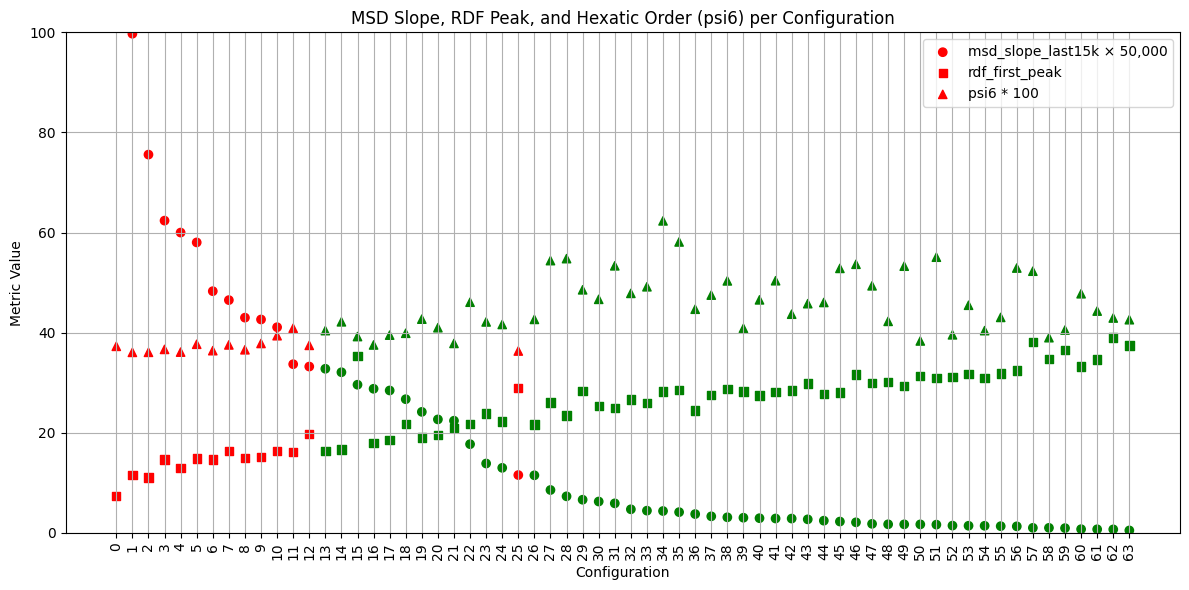

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Check if msd_slope equals msd_slope_last15k ---
if np.allclose(merged_df['msd_slope'].values, merged_df['msd_slope_last15k'].values, rtol=1e-8, atol=1e-8):
    print("msd_slope is equal to msd_slope_last15k for all configurations.")
else:
    print("msd_slope is NOT equal to msd_slope_last15k for some configurations.")
    diff = merged_df['msd_slope'] - merged_df['msd_slope_last15k']
    print("Differences:\n", diff)

# --- Plot msd_slope_last15k, rdf_first_peak, and psi6 ---

configs = merged_df.index.tolist()
x = np.arange(len(configs))
colors = ['red' if status.strip() == 'unstable' else 'green' for status in merged_df['status']]

plt.figure(figsize=(12, 6))

# Plot MSD slope
plt.scatter(x, merged_df['msd_slope_last15k'] * 50000, c=colors, marker='o', label='msd_slope_last15k × 50,000')

# Plot RDF first peak
plt.scatter(x, merged_df['rdf_first_peak'], c=colors, marker='s', label='rdf_first_peak')

# Plot psi6 (hexatic order)
plt.scatter(x, merged_df['psi6'] * 100, c=colors, marker='^', label='psi6 * 100')

plt.xticks(x, configs, rotation=90)
plt.xlabel("Configuration")
plt.ylabel("Metric Value")
plt.title("MSD Slope, RDF Peak, and Hexatic Order (psi6) per Configuration")
plt.legend()
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()


In [175]:
merged_df['psi_to_msd'] = merged_df['psi6'] / merged_df['msd_slope_last15k']

In [179]:
merged_df

config  msd_slope           status  msd_slope_last15k  rdf_first_peak  \
0   config_54   0.004738         unstable           0.004738          7.3697   
1    config_1   0.001994         unstable           0.001994         11.6219   
2   config_37   0.001512         unstable           0.001512         11.0912   
3    config_9   0.001248         unstable           0.001248         14.6832   
4   config_61   0.001200         unstable           0.001200         12.9211   
..        ...        ...              ...                ...             ...   
59  config_14   0.000019           stable           0.000019         36.5921   
60  config_15   0.000015           stable           0.000015         33.2419   
61  config_18   0.000015   stable #solid?           0.000015         34.6212   
62  config_52   0.000014   stable #solid?           0.000014         39.0511   
63  config_41   0.000010           stable           0.000010         37.4606   

        psi6    psi_to_msd  
0   0.372832     78.688573  
1   0.360789    180.903776  
2   0.360873    238.738483  
3   0.366703    293.883255  
4   0.361271    301.044779  
..       ...           ...  
59  0.405403  20949.799134  
60  0.477863  31550.918920  
61  0.443235  30152.896641  
62  0.429404  29935.233748  
63  0.426009  42072.494545  

[64 rows x 7 columns]

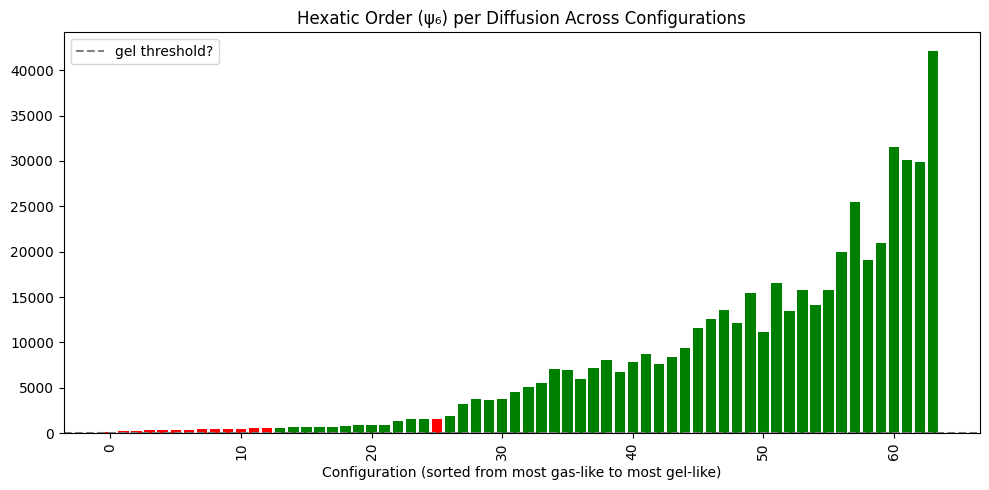

In [178]:
plt.figure(figsize=(10, 5))

plt.bar(configs, merged_df['psi_to_msd'], color=colors)
plt.xticks(rotation=90)
plt.xlabel("Configuration (sorted from most gas-like to most gel-like)")
#plt.ylabel("ψ₆ (Hexatic Order)")
plt.title("Hexatic Order (ψ₆) per Diffusion Across Configurations")
plt.axhline(0.5, color='gray', linestyle='--', label='gel threshold?')
plt.legend()
plt.tight_layout()
plt.show()


In [183]:
import MDAnalysis as mda
import numpy as np
from scipy.spatial import ConvexHull
import pandas as pd
import os

apl_data = []

for i in range(1,65):
    folder = f"config_{i}"
    data_file = os.path.join(folder, "bilayer.data")
    traj_file = os.path.join(folder, "full_traj.lammpstrj")

    try:
        u = mda.Universe(data_file, traj_file, format="LAMMPSDUMP")
        u.trajectory[-1]  # last frame

        heads = u.select_atoms("type 1 or type 8 or type 9")

        center = heads.center_of_mass()
        positions = heads.positions
        radii = np.linalg.norm(positions - center, axis=1)

        threshold = np.median(radii)
        outer = heads[radii > threshold]
        inner = heads[radii <= threshold]

        # Safety check: make sure we have enough atoms for ConvexHull
        if len(inner) < 4 or len(outer) < 4:
            raise ValueError("Not enough atoms for ConvexHull.")

        outer_hull = ConvexHull(outer.positions)
        inner_hull = ConvexHull(inner.positions)

        apl_outer = outer_hull.area / len(outer.residues)
        apl_inner = inner_hull.area / len(inner.residues)

        apl_data.append({
            "config": f"config_{i}",
            "APL_outer": apl_outer,
            "APL_inner": apl_inner
        })

    except Exception as e:
        print(f"[!] Failed on {folder}: {e}")
        apl_data.append({
            "config": f"config_{i}",
            "APL_outer": np.nan,
            "APL_inner": np.nan
        })

# Convert to DataFrame
df_apl = pd.DataFrame(apl_data)
#df_apl.to_csv("apl_per_leaflet.csv", index=False)
print(df_apl.head())


     config  APL_outer  APL_inner
0  config_1   4.453967   1.440416
1  config_2   3.875165   1.416017
2  config_3   1.352672   1.195448
3  config_4   1.415319   1.268867
4  config_5   2.001207   1.358193


In [186]:
# Merge with your existing merged_df on the 'config' column
merged_df = merged_df.merge(df_apl, on="config", how="left")
merged_df

config  msd_slope           status  msd_slope_last15k  rdf_first_peak  \
0   config_54   0.004738         unstable           0.004738          7.3697   
1    config_1   0.001994         unstable           0.001994         11.6219   
2   config_37   0.001512         unstable           0.001512         11.0912   
3    config_9   0.001248         unstable           0.001248         14.6832   
4   config_61   0.001200         unstable           0.001200         12.9211   
..        ...        ...              ...                ...             ...   
59  config_14   0.000019           stable           0.000019         36.5921   
60  config_15   0.000015           stable           0.000015         33.2419   
61  config_18   0.000015   stable #solid?           0.000015         34.6212   
62  config_52   0.000014   stable #solid?           0.000014         39.0511   
63  config_41   0.000010           stable           0.000010         37.4606   

        psi6    psi_to_msd  APL_outer  APL_inner  
0   0.372832     78.688573   5.809234   1.445206  
1   0.360789    180.903776   4.453967   1.440416  
2   0.360873    238.738483   4.235171   1.390832  
3   0.366703    293.883255   4.041239   1.389361  
4   0.361271    301.044779   3.862266   1.206169  
..       ...           ...        ...        ...  
59  0.405403  20949.799134   1.110279   0.959396  
60  0.477863  31550.918920   1.234905   1.099040  
61  0.443235  30152.896641   1.192173   1.048927  
62  0.429404  29935.233748   1.071272   0.940288  
63  0.426009  42072.494545   1.044100   0.935405  

[64 rows x 9 columns]

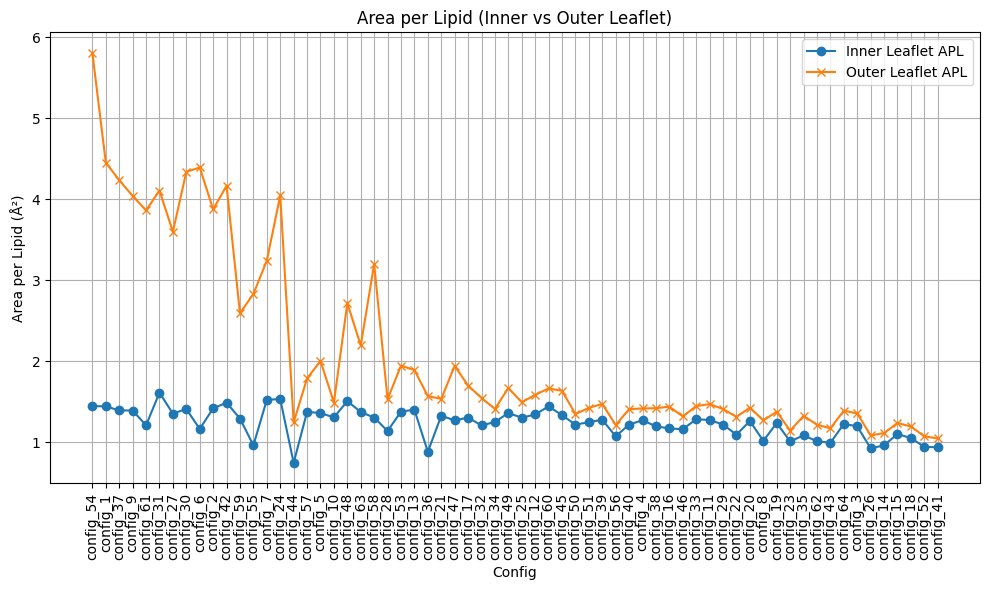

In [187]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(merged_df['config'], merged_df['APL_inner'], label='Inner Leaflet APL', marker='o')
plt.plot(merged_df['config'], merged_df['APL_outer'], label='Outer Leaflet APL', marker='x')
plt.xticks(rotation=90)
plt.ylabel("Area per Lipid (Å²)")
plt.xlabel("Config")
plt.title("Area per Lipid (Inner vs Outer Leaflet)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


msd_slope is equal to msd_slope_last15k for all configurations.


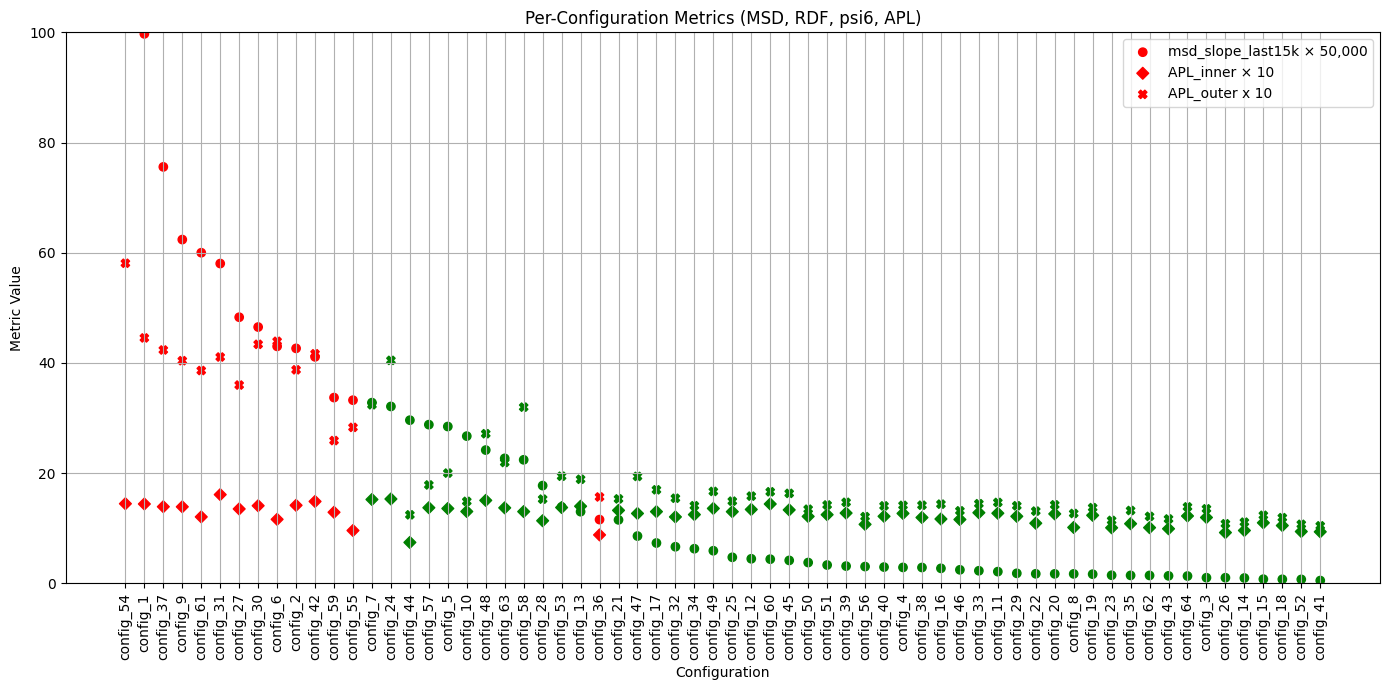

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Check if msd_slope equals msd_slope_last15k ---
if np.allclose(merged_df['msd_slope'].values, merged_df['msd_slope_last15k'].values, rtol=1e-8, atol=1e-8):
    print("msd_slope is equal to msd_slope_last15k for all configurations.")
else:
    print("msd_slope is NOT equal to msd_slope_last15k for some configurations.")
    diff = merged_df['msd_slope'] - merged_df['msd_slope_last15k']
    print("Differences:\n", diff)

# --- Plot all metrics: msd_slope, rdf_first_peak, psi6, APLs ---

configs = merged_df.index.tolist()
x = np.arange(len(configs))
colors = ['red' if status.strip() == 'unstable' else 'green' for status in merged_df['status']]

plt.figure(figsize=(14, 7))

# MSD slope
plt.scatter(x, merged_df['msd_slope_last15k'] * 50000, c=colors, marker='o', label='msd_slope_last15k × 50,000')

# RDF first peak
#plt.scatter(x, merged_df['rdf_first_peak'], c=colors, marker='s', label='rdf_first_peak')

# Hexatic order
#plt.scatter(x, merged_df['psi6'] * 100, c=colors, marker='^', label='psi6 × 100')

# APL (Area per lipid), scaled × 50 for visibility
plt.scatter(x, merged_df['APL_inner'] *10, c=colors, marker='D', label='APL_inner × 10')
plt.scatter(x, merged_df['APL_outer']*10, c=colors, marker='X', label='APL_outer x 10')

# Axis and formatting
plt.xticks(x, merged_df['config'], rotation=90)
plt.xlabel("Configuration")
plt.ylabel("Metric Value")
plt.title("Per-Configuration Metrics (MSD, RDF, psi6, APL)")
plt.legend()
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()


/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/MDAnalysis/coordinates/LAMMPS.py:667: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data['time'] = step_num * ts.dt


Config config_1: psi6 = 0.3608
Config config_10: psi6 = 0.3989
Config config_11: psi6 = 0.5367
Config config_12: psi6 = 0.4918
Config config_13: psi6 = 0.4165
Config config_14: psi6 = 0.4054
Config config_15: psi6 = 0.4779
Config config_16: psi6 = 0.4581
Config config_17: psi6 = 0.5480
Config config_18: psi6 = 0.4432
Config config_19: psi6 = 0.5509
Config config_2: psi6 = 0.3785
Config config_20: psi6 = 0.5329
Config config_21: psi6 = 0.4266
Config config_22: psi6 = 0.4227
Config config_23: psi6 = 0.3958
Config config_24: psi6 = 0.4218
Config config_25: psi6 = 0.4786
Config config_26: psi6 = 0.3901
Config config_27: psi6 = 0.3642
Config config_28: psi6 = 0.4610
Config config_29: psi6 = 0.4937
Config config_3: psi6 = 0.5229
Config config_30: psi6 = 0.3756
Config config_31: psi6 = 0.3769
Config config_32: psi6 = 0.4857
Config config_33: psi6 = 0.5285
Config config_34: psi6 = 0.4667
Config config_35: psi6 = 0.4549
Config config_36: psi6 = 0.3635
Config config_37: psi6 = 0.3609
Config conf

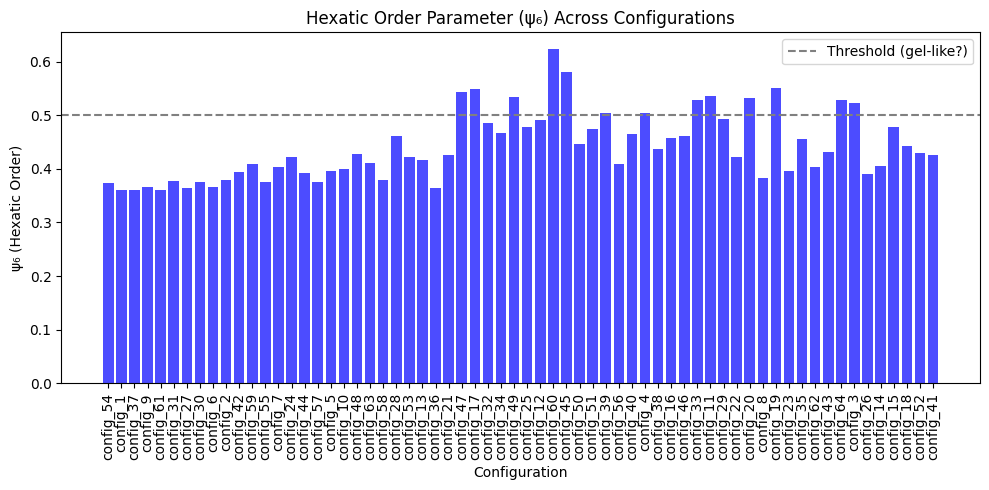

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MDAnalysis as mda
import networkx as nx
from scipy.spatial import cKDTree

merged_df = pd.read_csv("merged_df.csv")	


# --- CONFIGURATION ---
CONFIG_ROOT = "."  # Parent folder containing config_* folders
DATA_FILE = "bilayer.data"
TRAJ_FILE = "full_traj.lammpstrj"
FRAME = -1           # Use the last frame of the trajectory
CUTOFF = 6.0        # Cutoff distance (adjust units as needed)

# --- GROUPING BEADS INTO LIPIDS ---
def group_lipids(u):
    """
    Build a graph from the bonds in the Universe.
    Each connected component of the graph is assumed to be one lipid.
    """
    G = nx.Graph()
    for atom in u.atoms:
        G.add_node(atom.index)
    if hasattr(u, 'bonds'):
        for bond in u.bonds:
            i = bond.atoms[0].index
            j = bond.atoms[1].index
            G.add_edge(i, j)
    else:
        raise RuntimeError("No bond information found in Universe. "
                           "Make sure your LAMMPS data file includes bonds.")
    # Each connected component represents a lipid
    lipid_components = list(nx.connected_components(G))
    # Optionally, filter components by size (here, require at least 3 atoms)
    lipid_components = [comp for comp in lipid_components if len(comp) >= 3]
    return lipid_components

def compute_com_for_lipid(u, indices):
    """
    Compute the center-of-mass for a lipid defined by a set of atom indices.
    Assumes equal mass for simplicity.
    """
    positions = np.array([u.atoms[i].position for i in indices])
    return positions.mean(axis=0)

# --- LOCAL TANGENT PLANE CONSTRUCTION ---
def local_tangent_basis(r):
    """
    Given a radial vector r from the sphere center, compute two perpendicular unit
    vectors (e1, e2) spanning the tangent plane at that point.
    """
    r_norm = np.linalg.norm(r)
    if r_norm < 1e-8:
        raise ValueError("Zero radial vector encountered!")
    r_unit = r / r_norm
    # Choose an arbitrary vector not parallel to r_unit
    arbitrary = np.array([1, 0, 0]) if abs(r_unit[0]) < 0.9 else np.array([0, 1, 0])
    # Remove the component along r_unit
    e1 = arbitrary - np.dot(arbitrary, r_unit) * r_unit
    e1 /= np.linalg.norm(e1)
    e2 = np.cross(r_unit, e1)
    return e1, e2

# --- HEXATIC ORDER CALCULATION USING LIPID COMs ---
def compute_hexatic_order_lipids(datafile, trajfile, cutoff=CUTOFF, frame=FRAME):
    """
    Load the LAMMPS data (and trajectory) and compute the hexatic order parameter
    for the lipid COMs. The procedure is:
      1. Group atoms into lipids using bond connectivity.
      2. Compute COM of each lipid.
      3. Estimate the global sphere center as the mean of COMs.
      4. For each lipid, define a local tangent plane (based on its radial vector)
         and compute angles to its neighbors (found via a KDTree).
      5. Calculate the local sixfold order parameter ψ₆ and average over lipids.
    """
    # Load Universe (using the LAMMPSDUMP format)
    u = mda.Universe(datafile, trajfile, format="LAMMPSDUMP")
    u.trajectory[frame]  # select the desired frame

    # Group beads into lipids using bond connectivity
    lipid_components = group_lipids(u)

    # Compute COM positions for each lipid
    lipid_COMs = []
    for comp in lipid_components:
        com = compute_com_for_lipid(u, comp)
        lipid_COMs.append(com)
    lipid_COMs = np.array(lipid_COMs)

    # Estimate the sphere center as the mean COM position
    center = lipid_COMs.mean(axis=0)

    # Build a KDTree for neighbor search among lipid COMs
    tree = cKDTree(lipid_COMs)
    n_lipids = len(lipid_COMs)

    psi6_values = []
    for i in range(n_lipids):
        pos_i = lipid_COMs[i]
        # Radial vector for lipid i
        r_vec = pos_i - center
        try:
            e1, e2 = local_tangent_basis(r_vec)
        except ValueError:
            continue  # skip if something goes wrong
        # Find the 7 nearest neighbors (including self)
        dists, indices = tree.query(pos_i, k=7)
        neighbor_angles = []
        for dist, j in zip(dists[1:], indices[1:]):  # skip self (first element)
            if dist > cutoff:
                continue
            pos_j = lipid_COMs[j]
            disp = pos_j - pos_i
            # Project disp onto the local tangent plane
            r_unit = r_vec / np.linalg.norm(r_vec)
            proj = disp - np.dot(disp, r_unit) * r_unit
            # Express in local basis (e1, e2)
            x_proj = np.dot(proj, e1)
            y_proj = np.dot(proj, e2)
            angle = np.arctan2(y_proj, x_proj)
            neighbor_angles.append(angle)
        if len(neighbor_angles) == 0:
            psi6_values.append(0.0)
        else:
            op_complex = np.mean(np.exp(1j * 6 * np.array(neighbor_angles)))
            psi6_values.append(np.abs(op_complex))
    if len(psi6_values) == 0:
        return np.nan
    return np.mean(psi6_values)

# --- BATCH ANALYSIS OVER CONFIG FOLDERS ---
def batch_hexatic(config_root):
    results = []
    # Loop over items in the config_root directory
    for item in sorted(os.listdir(config_root)):
        folder = os.path.join(config_root, item)
        # Only consider directories that contain both data and trajectory files
        data_path = os.path.join(folder, DATA_FILE)
        traj_path = os.path.join(folder, TRAJ_FILE)
        if not (os.path.isdir(folder) and os.path.isfile(data_path) and os.path.isfile(traj_path)):
            continue
        try:
            psi6_val = compute_hexatic_order_lipids(data_path, traj_path)
            results.append((item, psi6_val))
            print(f"Config {item}: psi6 = {psi6_val:.4f}")
        except Exception as e:
            print(f"[!] Failed on {item}: {e}")
            results.append((item, np.nan))
    return pd.DataFrame(results, columns=["config", "psi6"])

# --- MERGE WITH EXISTING merged_df ---
# Assume merged_df is already saved/loaded (e.g., via CSV)

# Run the batch hexatic analysis over all configs in CONFIG_ROOT
df_hexatic = batch_hexatic(CONFIG_ROOT)

# Merge hexatic data into merged_df (based on config folder names)
merged_df = merged_df.merge(df_hexatic, on="config", how="left")
merged_df.to_csv("merged_df_with_hexatic.csv", index=False)
print("Merged hexatic order (psi6) into merged_df and saved to 'merged_df_with_hexatic.csv'.")

# --- OPTIONAL: Plot psi6 Only ---
configs = merged_df['config']
x = np.arange(len(merged_df))

plt.figure(figsize=(10, 5))
plt.bar(x, merged_df['psi6'], color='blue', alpha=0.7)
plt.xticks(x, configs, rotation=90)
plt.xlabel("Configuration")
plt.ylabel("ψ₆ (Hexatic Order)")
plt.title("Hexatic Order Parameter (ψ₆) Across Configurations")
plt.axhline(0.5, color='gray', linestyle='--', label='Threshold (gel-like?)')
plt.legend()
plt.tight_layout()
plt.show()


In [139]:
merged_df

config  msd_slope           status  msd_slope_last15k  rdf_first_peak  \
0   config_54   0.004738         unstable           0.004738          7.3697   
1    config_1   0.001994         unstable           0.001994         11.6219   
2   config_37   0.001512         unstable           0.001512         11.0912   
3    config_9   0.001248         unstable           0.001248         14.6832   
4   config_61   0.001200         unstable           0.001200         12.9211   
..        ...        ...              ...                ...             ...   
59  config_14   0.000019           stable           0.000019         36.5921   
60  config_15   0.000015           stable           0.000015         33.2419   
61  config_18   0.000015   stable #solid?           0.000015         34.6212   
62  config_52   0.000014   stable #solid?           0.000014         39.0511   
63  config_41   0.000010           stable           0.000010         37.4606   

        psi6  
0   0.372832  
1   0.360789  
2   0.360873  
3   0.366703  
4   0.361271  
..       ...  
59  0.405403  
60  0.477863  
61  0.443235  
62  0.429404  
63  0.426009  

[64 rows x 6 columns]

In [154]:
merged_df[27:]['config']

27    config_47
28    config_17
29    config_32
30    config_34
31    config_49
32    config_25
33    config_12
34    config_60
35    config_45
36    config_50
37    config_51
38    config_39
39    config_56
40    config_40
41     config_4
42    config_38
43    config_16
44    config_46
45    config_33
46    config_11
47    config_29
48    config_22
49    config_20
50     config_8
51    config_19
52    config_23
53    config_35
54    config_62
55    config_43
56    config_64
57     config_3
58    config_26
59    config_14
60    config_15
61    config_18
62    config_52
63    config_41
Name: config, dtype: object

In [160]:
params = pd.read_csv("parameter_samples.csv")

In [136]:
params['status'].describe()

count         64
unique         2
top       stable
freq          50
Name: status, dtype: object

In [138]:
params

k_bend_saturated  k_bend_unsaturated  k_bend_cholesterol  w_c_default  \
0          11.422428            1.620071            7.106316     0.959733   
1          10.133905            5.205917            3.878774     1.416595   
2           7.552117            8.788101            8.498987     2.416922   
3           4.383901            8.083707            6.136164     1.482366   
4          12.375734            1.899940           10.810740     1.592721   
..               ...                 ...                 ...          ...   
59         17.583064            4.764086           11.931013     1.568790   
60          8.586510            6.490490           11.279667     1.226878   
61          4.466159            3.922506            9.886832     1.937024   
62          7.594832            3.039634            1.783131     1.215145   
63         19.481477            4.242350            7.844934     2.104338   

     w_c_U-S   w_c_U-C   w_c_C-S  Temperature  outer_typeOne  outer_typeTwo  \
0   1.367492  1.543889  1.674346     1.344913       0.413212       0.148187   
1   1.771953  1.279933  0.995776     1.504326       0.123749       0.610003   
2   2.381959  1.541134  1.480404     1.028319       0.713556       0.190624   
3   1.431776  1.878525  2.113463     0.970237       0.374749       0.336342   
4   1.216442  0.839303  0.948605     1.316478       0.793382       0.165165   
..       ...       ...       ...          ...            ...            ...   
59  0.807284  1.929573  0.841134     0.807790       0.625053       0.364219   
60  0.909134  0.934122  1.850319     1.327542       0.699053       0.206002   
61  1.936466  0.877510  1.623155     1.011451       0.199589       0.257803   
62  0.974143  2.117305  2.236298     0.952376       0.538713       0.416038   
63  2.080820  1.638443  2.382112     0.977157       0.618821       0.230640   

    inner_typeThr  inner_typeFour    status  
0        0.712130        0.234671  unstable  
1        0.760324        0.119170  unstable  
2        0.339014        0.417316    stable  
3        0.664531        0.156645    stable  
4        0.143609        0.565495    stable  
..            ...             ...       ...  
59       0.851467        0.128559    stable  
60       0.148962        0.421761  unstable  
61       0.500675        0.226228    stable  
62       0.477895        0.399396    stable  
63       0.344173        0.573555    stable  

[64 rows x 13 columns]

In [161]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score

# Assuming 'params' is your DataFrame
X = params.drop(columns='status')
y = params['status']

# If 'status' is not binary 0/1 yet, convert it
y = y.map({'stable': 0, 'unstable': 1})  # Adjust mapping if needed

# Create logistic regression pipeline with scaling
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

# Stratified 3-fold cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Evaluate different metrics
accuracy_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
f1_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1')
roc_auc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')

# Print results
print(f"3-fold CV accuracy: {accuracy_scores.mean():.3f} ± {accuracy_scores.std():.3f}")
print(f"3-fold CV F1 score: {f1_scores.mean():.3f} ± {f1_scores.std():.3f}")
print(f"3-fold CV ROC AUC:  {roc_auc_scores.mean():.3f} ± {roc_auc_scores.std():.3f}")


3-fold CV accuracy: 0.906 ± 0.039
3-fold CV F1 score: 0.753 ± 0.134
3-fold CV ROC AUC:  0.958 ± 0.034


In [163]:
params['status'].describe()

count           64
unique           2
top       unstable
freq            51
Name: status, dtype: object

In [162]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# List of extra configs to force as unstable (converted to row indices)
extra_unstable_indices = [
    int(cfg.split('_')[1]) - 1 for cfg in [
        'config_47', 'config_17', 'config_32', 'config_34', 'config_49',
        'config_25', 'config_12', 'config_60', 'config_45', 'config_50',
        'config_51', 'config_39', 'config_56', 'config_40', 'config_4',
        'config_38', 'config_16', 'config_46', 'config_33', 'config_11',
        'config_29', 'config_22', 'config_20', 'config_8', 'config_19',
        'config_23', 'config_35', 'config_62', 'config_43', 'config_64',
        'config_3', 'config_26', 'config_14', 'config_15', 'config_18',
        'config_52', 'config_41'
    ]
]

# Make a copy of the original status to avoid overwriting
params = params.copy()

# Force those indices to 'unstable' (preserve all existing unstable labels)
params.loc[extra_unstable_indices, 'status'] = 'unstable'

# Prepare features and labels
X = params.drop(columns=['status'])
y = params['status'].map({'stable': 0, 'unstable': 1})  # Binary labels

# Build the pipeline
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

# 3-fold stratified cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Evaluate with accuracy, F1, and ROC AUC
accuracy_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
f1_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1')
roc_auc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')

# Print results
print(f"3-fold CV accuracy: {accuracy_scores.mean():.3f} ± {accuracy_scores.std():.3f}")
print(f"3-fold CV F1 score: {f1_scores.mean():.3f} ± {f1_scores.std():.3f}")
print(f"3-fold CV ROC AUC:  {roc_auc_scores.mean():.3f} ± {roc_auc_scores.std():.3f}")


3-fold CV accuracy: 0.705 ± 0.089
3-fold CV F1 score: 0.818 ± 0.069
3-fold CV ROC AUC:  0.515 ± 0.130


In [165]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

# List of extra configs to mark as unstable
extra_unstable_indices = [
    int(cfg.split('_')[1]) - 1 for cfg in [
        'config_47', 'config_17', 'config_32', 'config_34', 'config_49',
        'config_25', 'config_12', 'config_60', 'config_45', 'config_50',
        'config_51', 'config_39', 'config_56', 'config_40', 'config_4',
        'config_38', 'config_16', 'config_46', 'config_33', 'config_11',
        'config_29', 'config_22', 'config_20', 'config_8', 'config_19',
        'config_23', 'config_35', 'config_62', 'config_43', 'config_64',
        'config_3', 'config_26', 'config_14', 'config_15', 'config_18',
        'config_52', 'config_41'
    ]
]

# Copy and update status column
params = params.copy()
params.loc[extra_unstable_indices, 'status'] = 'unstable'

# Define features and labels
X = params.drop(columns=['status'])
y = params['status'].map({'stable': 0, 'unstable': 1})  # Binary labels: 0 = stable, 1 = unstable

# Create pipeline with oversampling, scaling, and logistic regression
pipeline = ImbPipeline(steps=[
    ('oversample', RandomOverSampler(random_state=42)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

# Stratified 3-fold CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Evaluate metrics
accuracy_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
f1_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1')
roc_auc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')

# Output results
print(f"3-fold CV accuracy: {accuracy_scores.mean():.3f} ± {accuracy_scores.std():.3f}")
print(f"3-fold CV F1 score: {f1_scores.mean():.3f} ± {f1_scores.std():.3f}")
print(f"3-fold CV ROC AUC:  {roc_auc_scores.mean():.3f} ± {roc_auc_scores.std():.3f}")


3-fold CV accuracy: 0.611 ± 0.111
3-fold CV F1 score: 0.740 ± 0.084
3-fold CV ROC AUC:  0.510 ± 0.147


In [167]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

# Update unstable labels as before
extra_unstable_indices = [
    int(cfg.split('_')[1]) - 1 for cfg in [
        'config_47', 'config_17', 'config_32', 'config_34', 'config_49',
        'config_25', 'config_12', 'config_60', 'config_45', 'config_50',
        'config_51', 'config_39', 'config_56', 'config_40', 'config_4',
        'config_38', 'config_16', 'config_46', 'config_33', 'config_11',
        'config_29', 'config_22', 'config_20', 'config_8', 'config_19',
        'config_23', 'config_35', 'config_62', 'config_43', 'config_64',
        'config_3', 'config_26', 'config_14', 'config_15', 'config_18',
        'config_52', 'config_41'
    ]
]

params = params.copy()
params.loc[extra_unstable_indices, 'status'] = 'unstable'

# Feature matrix and binary target
X = params.drop(columns=['status'])
y = params['status'].map({'stable': 0, 'unstable': 1})

# Setup
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
smote = SMOTE(random_state=42)
scaler = StandardScaler()
clf = LogisticRegression(max_iter=1000)

# Score containers
accs, f1s, aucs = [], [], []

# Cross-validation loop
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Before SMOTE
    print(f"\nFold {fold_idx} - Training before SMOTE:")
    print(pd.Series(y_train).value_counts().rename(index={0: 'Stable', 1: 'Unstable'}))

    # Apply SMOTE to training data only
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # After SMOTE
    print(f"Fold {fold_idx} - Training after SMOTE:")
    print(pd.Series(y_train_res).value_counts().rename(index={0: 'Stable', 1: 'Unstable'}))

    # Test set
    print(f"Fold {fold_idx} - Test set:")
    print(pd.Series(y_test).value_counts().rename(index={0: 'Stable', 1: 'Unstable'}))

    # Pipeline
    X_train_scaled = scaler.fit_transform(X_train_res)
    X_test_scaled = scaler.transform(X_test)
    clf.fit(X_train_scaled, y_train_res)

    y_pred = clf.predict(X_test_scaled)
    y_prob = clf.predict_proba(X_test_scaled)[:, 1]

    # Metrics
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    aucs.append(roc_auc_score(y_test, y_prob))

# Summary
print("\n--- Cross-Validation Results with SMOTE ---")
print(f"Accuracy:  {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"F1 Score:  {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
print(f"ROC AUC:   {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")



Fold 1 - Training before SMOTE:
status
Unstable    34
Stable       8
Name: count, dtype: int64
Fold 1 - Training after SMOTE:
status
Unstable    34
Stable      34
Name: count, dtype: int64
Fold 1 - Test set:
status
Unstable    17
Stable       5
Name: count, dtype: int64

Fold 2 - Training before SMOTE:
status
Unstable    34
Stable       9
Name: count, dtype: int64
Fold 2 - Training after SMOTE:
status
Unstable    34
Stable      34
Name: count, dtype: int64
Fold 2 - Test set:
status
Unstable    17
Stable       4
Name: count, dtype: int64

Fold 3 - Training before SMOTE:
status
Unstable    34
Stable       9
Name: count, dtype: int64
Fold 3 - Training after SMOTE:
status
Unstable    34
Stable      34
Name: count, dtype: int64
Fold 3 - Test set:
status
Unstable    17
Stable       4
Name: count, dtype: int64

--- Cross-Validation Results with SMOTE ---
Accuracy:  0.610 ± 0.074
F1 Score:  0.742 ± 0.052
ROC AUC:   0.501 ± 0.153


In [173]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Add your own data loading here if needed
# --------------------
# Mark extra configs as unstable
extra_unstable_indices = [
    int(cfg.split('_')[1]) - 1 for cfg in [
        'config_47', 'config_17', 'config_32', 'config_34', 'config_49',
        'config_25', 'config_12', 'config_60', 'config_45', 'config_50',
        'config_51', 'config_39', 'config_56', 'config_40', 'config_4',
        'config_38', 'config_16', 'config_46', 'config_33', 'config_11',
        'config_29', 'config_22', 'config_20', 'config_8', 'config_19',
        'config_23', 'config_35', 'config_62', 'config_43', 'config_64',
        'config_3', 'config_26', 'config_14', 'config_15', 'config_18',
        'config_52', 'config_41'
    ]
]
params = params.copy()
params.loc[extra_unstable_indices, 'status'] = 'unstable'

# Feature matrix and binary target
X = params.drop(columns=['status'])
y = params['status'].map({'stable': 0, 'unstable': 1})
# --------------------

# Setup
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
smote = SMOTE(random_state=42)
scaler = StandardScaler()

# Stronger L2 regularization (C < 1)
clf = LogisticRegression(penalty='elasticnet', l1_ratio=0.95, solver='saga', max_iter=1000)

# Score containers
train_accs, train_f1s, train_aucs = [], [], []
test_accs, test_f1s, test_aucs = [], [], []

# Cross-validation loop
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Apply SMOTE to training data only
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Scale
    X_train_scaled = scaler.fit_transform(X_train_res)
    X_test_scaled = scaler.transform(X_test)

    # Fit model
    clf.fit(X_train_scaled, y_train_res)

    # Train set performance
    y_train_pred = clf.predict(X_train_scaled)
    y_train_prob = clf.predict_proba(X_train_scaled)[:, 1]
    train_accs.append(accuracy_score(y_train_res, y_train_pred))
    train_f1s.append(f1_score(y_train_res, y_train_pred))
    train_aucs.append(roc_auc_score(y_train_res, y_train_prob))

    # Test set performance
    y_test_pred = clf.predict(X_test_scaled)
    y_test_prob = clf.predict_proba(X_test_scaled)[:, 1]
    test_accs.append(accuracy_score(y_test, y_test_pred))
    test_f1s.append(f1_score(y_test, y_test_pred))
    test_aucs.append(roc_auc_score(y_test, y_test_prob))

    # Print class balance info
    print(f"\nFold {fold_idx}")
    print("  Train before SMOTE:", y_train.value_counts().to_dict())
    print("  Train after SMOTE: ", pd.Series(y_train_res).value_counts().to_dict())
    print("  Test set:          ", y_test.value_counts().to_dict())

# Summary of train vs test
print("\n--- Cross-Validation Results with SMOTE + L2 Regularization ---")
print("Train Accuracy: ", f"{np.mean(train_accs):.3f} ± {np.std(train_accs):.3f}")
print("Test Accuracy:  ", f"{np.mean(test_accs):.3f} ± {np.std(test_accs):.3f}")
print("Train F1 Score: ", f"{np.mean(train_f1s):.3f} ± {np.std(train_f1s):.3f}")
print("Test F1 Score:  ", f"{np.mean(test_f1s):.3f} ± {np.std(test_f1s):.3f}")
print("Train ROC AUC:  ", f"{np.mean(train_aucs):.3f} ± {np.std(train_aucs):.3f}")
print("Test ROC AUC:   ", f"{np.mean(test_aucs):.3f} ± {np.std(test_aucs):.3f}")



Fold 1
  Train before SMOTE: {1: 34, 0: 8}
  Train after SMOTE:  {1: 34, 0: 34}
  Test set:           {1: 17, 0: 5}

Fold 2
  Train before SMOTE: {1: 34, 0: 9}
  Train after SMOTE:  {1: 34, 0: 34}
  Test set:           {1: 17, 0: 4}

Fold 3
  Train before SMOTE: {1: 34, 0: 9}
  Train after SMOTE:  {1: 34, 0: 34}
  Test set:           {1: 17, 0: 4}

--- Cross-Validation Results with SMOTE + L2 Regularization ---
Train Accuracy:  0.882 ± 0.055
Test Accuracy:   0.595 ± 0.085
Train F1 Score:  0.878 ± 0.057
Test F1 Score:   0.729 ± 0.059
Train ROC AUC:   0.924 ± 0.060
Test ROC AUC:    0.539 ± 0.163


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
merged_df = pd.read_csv("merged_df_with_hexatic.csv")	

In [4]:
merged_df

config  msd_slope           status  msd_slope_last15k  rdf_first_peak  \
0   config_54   0.004738         unstable           0.004738          7.3697   
1    config_1   0.001994         unstable           0.001994         11.6219   
2   config_37   0.001512         unstable           0.001512         11.0912   
3    config_9   0.001248         unstable           0.001248         14.6832   
4   config_61   0.001200         unstable           0.001200         12.9211   
..        ...        ...              ...                ...             ...   
59  config_14   0.000019           stable           0.000019         36.5921   
60  config_15   0.000015           stable           0.000015         33.2419   
61  config_18   0.000015   stable #solid?           0.000015         34.6212   
62  config_52   0.000014   stable #solid?           0.000014         39.0511   
63  config_41   0.000010           stable           0.000010         37.4606   

        psi6  
0   0.372832  
1   0.360789  
2   0.360873  
3   0.366703  
4   0.361271  
..       ...  
59  0.405403  
60  0.477863  
61  0.443235  
62  0.429404  
63  0.426009  

[64 rows x 6 columns]

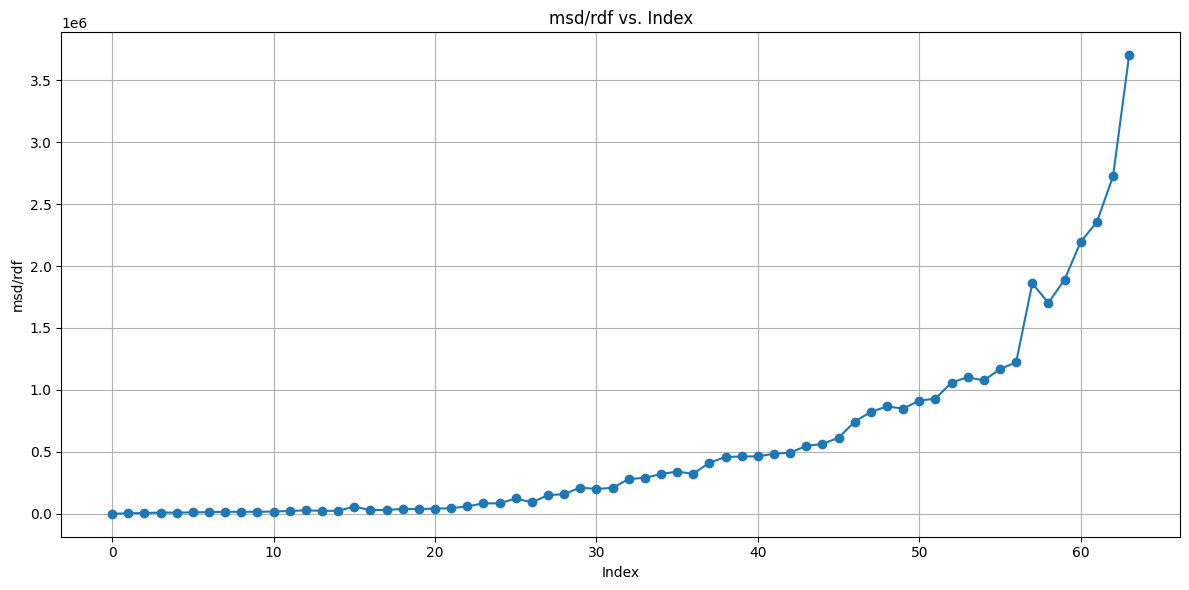

In [5]:
merged_df['rdf/msd'] = merged_df['rdf_first_peak'] / merged_df['msd_slope_last15k']
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, merged_df['rdf/msd'], marker='o')
plt.xlabel("Index")
plt.ylabel("msd/rdf")
plt.title("msd/rdf vs. Index")
plt.grid(True)
plt.tight_layout()
plt.show()

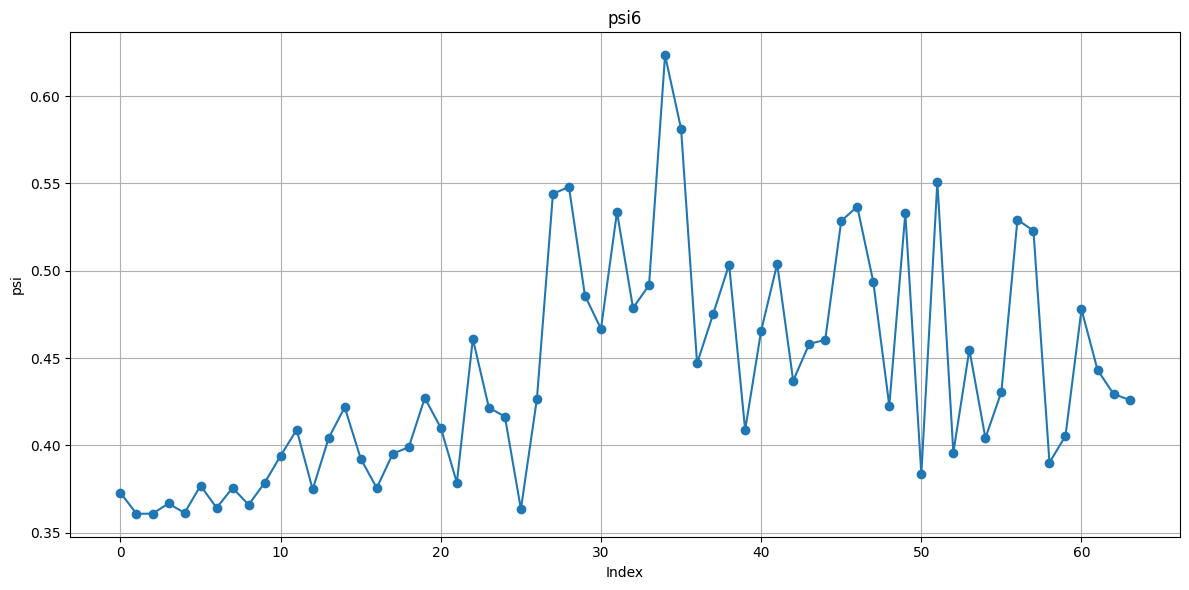

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, merged_df['psi6'] , marker='o')
plt.xlabel("Index")
plt.ylabel("psi")
plt.title("psi6")
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
merged_df['psi6/msd'] = merged_df['psi6'] / merged_df['msd_slope_last15k']

In [8]:
merged_df

config  msd_slope           status  msd_slope_last15k  rdf_first_peak  \
0   config_54   0.004738         unstable           0.004738          7.3697   
1    config_1   0.001994         unstable           0.001994         11.6219   
2   config_37   0.001512         unstable           0.001512         11.0912   
3    config_9   0.001248         unstable           0.001248         14.6832   
4   config_61   0.001200         unstable           0.001200         12.9211   
..        ...        ...              ...                ...             ...   
59  config_14   0.000019           stable           0.000019         36.5921   
60  config_15   0.000015           stable           0.000015         33.2419   
61  config_18   0.000015   stable #solid?           0.000015         34.6212   
62  config_52   0.000014   stable #solid?           0.000014         39.0511   
63  config_41   0.000010           stable           0.000010         37.4606   

        psi6       rdf/msd      psi6/msd  
0   0.372832  1.555422e+03     78.688573  
1   0.360789  5.827349e+03    180.903776  
2   0.360873  7.337469e+03    238.738483  
3   0.366703  1.176743e+04    293.883255  
4   0.361271  1.076707e+04    301.044779  
..       ...           ...           ...  
59  0.405403  1.890951e+06  20949.799134  
60  0.477863  2.194795e+06  31550.918920  
61  0.443235  2.355252e+06  30152.896641  
62  0.429404  2.722389e+06  29935.233748  
63  0.426009  3.699597e+06  42072.494545  

[64 rows x 8 columns]

In [9]:
import pandas as pd

# Create an empty list to store the results for each configuration.
results = []

for i in range(1, 65):
    config_name = f'config_{i}'
    
    # Read the file while skipping comment lines (lines starting with '#')
    data = pd.read_csv(f'{config_name}/global_adapt.out', comment='#', sep='\s+', header=None)
    
    # The file is structured as follows:
    # Column0: "Step:"    | Column1: TimeStep
    # Column2: "KE:"      | Column3: KE
    # Column4: "PE:"      | Column5: PE
    # Column6: "Tot:"     | Column7: Tot
    # Column8: "Temp:"    | Column9: Temp
    #
    # Extract the numerical values from the odd-indexed columns.
    data = data.iloc[:, [1, 3, 5, 7, 9]]
    data.columns = ["TimeStep", "KE", "PE", "Tot", "Temp"]

    # Convert TimeStep to a numeric type.
    data['TimeStep'] = pd.to_numeric(data['TimeStep'])
    
    # Filter for the row corresponding to TimeStep 25000.
    # If multiple rows match (unlikely), .iloc[-1] takes the last one.
    data_last = data.loc[data['TimeStep'] == 15000].iloc[-1]
    
    # Extract KE, PE, and Tot values.
    KE_last = data_last["KE"]
    PE_last = data_last["PE"]
    Tot_last = data_last["Tot"]
    
    # Append the results, associating them with the config name.
    results.append((config_name, KE_last, PE_last, Tot_last))

# Create a DataFrame from the results.
last_df = pd.DataFrame(results, columns=['config', 'KE_last', 'PE_last', 'Tot_last'])

# Merge the new results with your existing merged_df.
merged_df = merged_df.merge(last_df, on='config', how='left')


<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_363540/373726774.py:10: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(f'{config_name}/global_adapt.out', comment='#', sep='\s+', header=None)


In [10]:
merged_df

config  msd_slope           status  msd_slope_last15k  rdf_first_peak  \
0   config_54   0.004738         unstable           0.004738          7.3697   
1    config_1   0.001994         unstable           0.001994         11.6219   
2   config_37   0.001512         unstable           0.001512         11.0912   
3    config_9   0.001248         unstable           0.001248         14.6832   
4   config_61   0.001200         unstable           0.001200         12.9211   
..        ...        ...              ...                ...             ...   
59  config_14   0.000019           stable           0.000019         36.5921   
60  config_15   0.000015           stable           0.000015         33.2419   
61  config_18   0.000015   stable #solid?           0.000015         34.6212   
62  config_52   0.000014   stable #solid?           0.000014         39.0511   
63  config_41   0.000010           stable           0.000010         37.4606   

        psi6       rdf/msd      psi6/msd   KE_last    PE_last   Tot_last  
0   0.372832  1.555422e+03     78.688573  2.156917  26.253406  28.410323  
1   0.360789  5.827349e+03    180.903776  2.010169  22.586223  24.596393  
2   0.360873  7.337469e+03    238.738483  1.917419  28.948067  30.865487  
3   0.366703  1.176743e+04    293.883255  2.119963  24.247266  26.367229  
4   0.361271  1.076707e+04    301.044779  2.002860  27.480757  29.483617  
..       ...           ...           ...       ...        ...        ...  
59  0.405403  1.890951e+06  20949.799134  1.622396  11.056744  12.679140  
60  0.477863  2.194795e+06  31550.918920  0.966316  12.640982  13.607298  
61  0.443235  2.355252e+06  30152.896641  0.942597  13.483807  14.426405  
62  0.429404  2.722389e+06  29935.233748  0.939635   9.658332  10.597967  
63  0.426009  3.699597e+06  42072.494545  1.045904   9.130413  10.176316  

[64 rows x 11 columns]

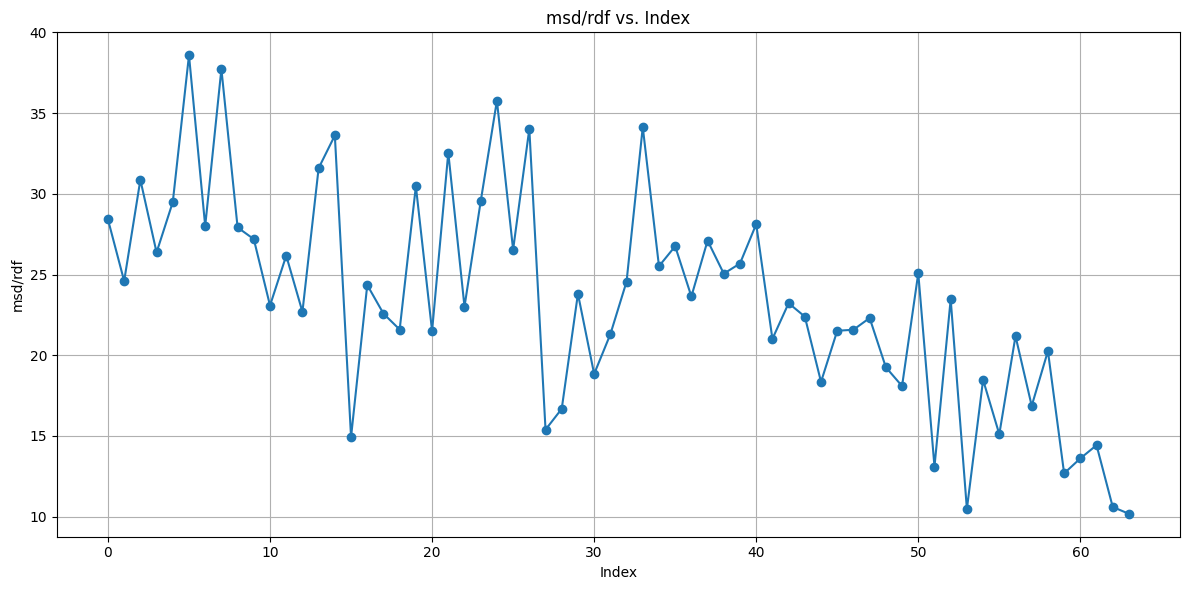

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, merged_df['Tot_last'], marker='o')
plt
plt.xlabel("Index")
plt.ylabel("msd/rdf")
plt.title("msd/rdf vs. Index")
plt.grid(True)
plt.tight_layout()
plt.show()

Processing ./config_1/full_traj.lammpstrj ...
Processing ./config_2/full_traj.lammpstrj ...
Processing ./config_3/full_traj.lammpstrj ...
Processing ./config_4/full_traj.lammpstrj ...
Processing ./config_5/full_traj.lammpstrj ...
Processing ./config_6/full_traj.lammpstrj ...
Processing ./config_7/full_traj.lammpstrj ...
Processing ./config_8/full_traj.lammpstrj ...
Processing ./config_9/full_traj.lammpstrj ...
Processing ./config_10/full_traj.lammpstrj ...
Processing ./config_11/full_traj.lammpstrj ...
Processing ./config_12/full_traj.lammpstrj ...
Processing ./config_13/full_traj.lammpstrj ...
Processing ./config_14/full_traj.lammpstrj ...
Processing ./config_15/full_traj.lammpstrj ...
Processing ./config_16/full_traj.lammpstrj ...
Processing ./config_17/full_traj.lammpstrj ...
Processing ./config_18/full_traj.lammpstrj ...
Processing ./config_19/full_traj.lammpstrj ...
Processing ./config_20/full_traj.lammpstrj ...
Processing ./config_21/full_traj.lammpstrj ...
Processing ./config_22

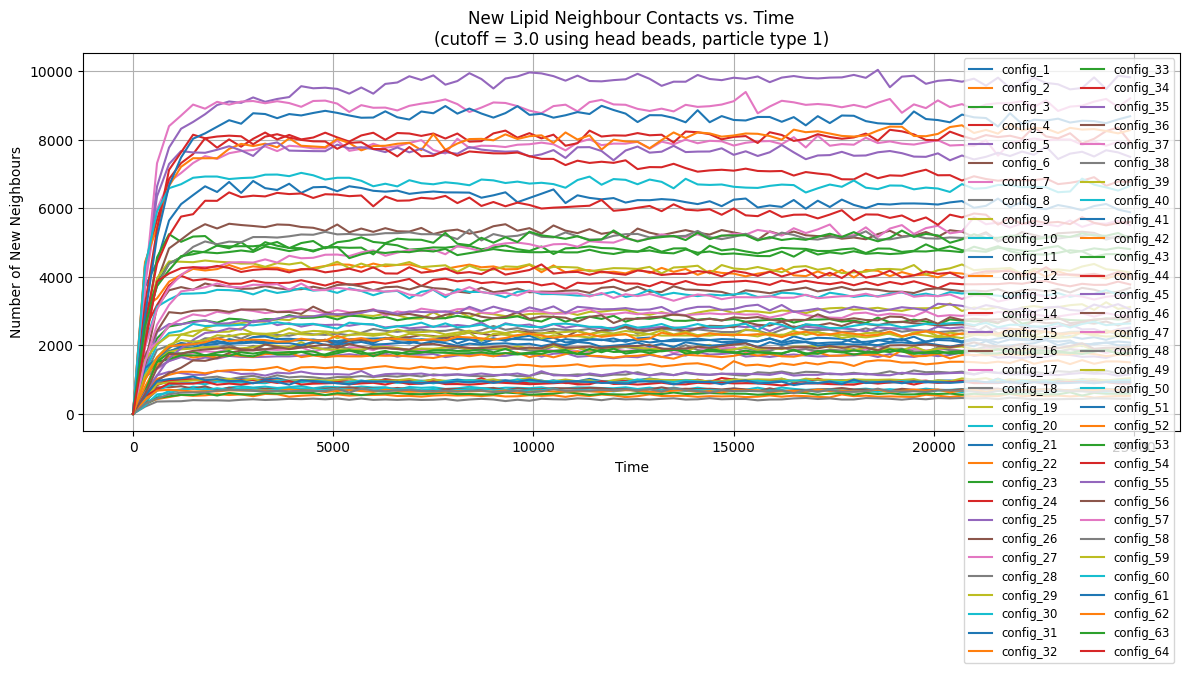

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# --- Function to read a LAMMPS trajectory file ---
def read_lammps_traj(filename):
    """
    Reads a LAMMPS trajectory file in dump format.
    
    Assumes the standard format:
      ITEM: TIMESTEP
      <timestep>
      ITEM: NUMBER OF ATOMS
      <natoms>
      ITEM: BOX BOUNDS ...        (three lines)
      ...
      ITEM: ATOMS id type x y z   (at least these 5 columns)
    
    Returns a list of frames.
    Each frame is a dictionary with keys:
         'time': timestep (int)
         'positions': numpy array of shape (N, 3) for the positions of particles
                      of particle type 1 (head beads).
    """
    frames = []
    with open(filename, 'r') as f:
        while True:
            # --- Read header for timestep ---
            line = f.readline()
            if not line:
                break  # EOF reached
            if "ITEM: TIMESTEP" in line:
                timestep = int(f.readline().strip())
            else:
                continue

            # --- Read number of atoms ---
            f.readline()  # "ITEM: NUMBER OF ATOMS"
            natoms = int(f.readline().strip())

            # --- Skip box bounds (3 lines) ---
            f.readline()  # "ITEM: BOX BOUNDS ..."
            for _ in range(3):
                f.readline()
                
            # --- Read atom data ---
            header = f.readline()  # "ITEM: ATOMS id type x y z ..." 
            atom_data = []
            for i in range(natoms):
                line = f.readline().strip()
                if not line:
                    break
                atom_data.append(line.split())
            
            # --- Filter out only head beads (particle type == 1) ---
            positions = []
            for row in atom_data:
                # Assumes that the second column is the atom type.
                # Adjust column indices if your trajectory has extra columns.
                if int(row[1]) == 1:
                    x = float(row[2])
                    y = float(row[3])
                    z = float(row[4])
                    positions.append([x, y, z])
            frames.append({'time': timestep, 'positions': np.array(positions)})
    return frames

# --- Function to compute neighbor pairs ---
def compute_neighbor_pairs(positions, cutoff=3.0):
    """
    Given a numpy array of positions (shape (N, 3)), returns a set of unique 
    unordered pairs (as tuples) of indices (i, j) (with i < j) that are within 
    the given cutoff distance.
    """
    if len(positions) == 0:
        return set()
    tree = cKDTree(positions)
    pairs = tree.query_pairs(r=cutoff)
    return pairs

# --- Loop through all configurations ---
base_dir = "."  # adjust if needed
configs = [d for d in os.listdir(base_dir)
           if d.startswith("config_") and os.path.isdir(os.path.join(base_dir, d))]
configs.sort(key=lambda x: int(x.split("_")[1]))

# Dictionary to store time and new neighbour counts for each config.
neighbor_changes_by_config = {}

# Iterate over each configuration folder.
for config in configs:
    traj_file = os.path.join(base_dir, config, "full_traj.lammpstrj")  # adjust filename if needed
    if not os.path.isfile(traj_file):
        print(f"Trajectory file not found for {config}")
        continue

    print(f"Processing {traj_file} ...")
    frames = read_lammps_traj(traj_file)
    if len(frames) == 0:
        continue

    times = []
    new_neighbors = []
    previous_pairs = None  # will hold neighbor pairs from the previous time step

    # Loop over frames in the trajectory.
    for frame in frames:
        t = frame['time']
        positions = frame['positions']
        # Compute the set of neighbor pairs (as index pairs) at this frame.
        current_pairs = compute_neighbor_pairs(positions, cutoff=3.0)
        
        if previous_pairs is None:
            # For the first frame, there are no "new" pairs to compare.
            new_count = 0
        else:
            # New neighbors are pairs that appear in the current frame but were not present in the previous frame.
            new_pairs = current_pairs - previous_pairs
            new_count = len(new_pairs)
        
        times.append(t)
        new_neighbors.append(new_count)
        previous_pairs = current_pairs  # update for next iteration

    neighbor_changes_by_config[config] = (np.array(times), np.array(new_neighbors))

# --- Plotting new neighbor counts for each config ---
plt.figure(figsize=(12, 6))
for config, (times, new_counts) in neighbor_changes_by_config.items():
    plt.plot(times, new_counts, label=config)

plt.xlabel("Time")
plt.ylabel("Number of New Neighbours")
plt.title("New Lipid Neighbour Contacts vs. Time\n(cutoff = 3.0 using head beads, particle type 1)")
plt.legend(fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
import numpy as np
import pandas as pd

# Compute the average new neighbor counts for time points between 10,000 and 15,000 for each config.
avg_neighbors_list = []
for config, (times, new_counts) in neighbor_changes_by_config.items():
    # Create a boolean mask that is True for times between 10,000 and 15,000 (inclusive).
    mask = (times >= 10000) & (times <= 15000)
    
    # Compute the average of new_counts for the time points within the mask.
    if np.any(mask):
        avg_value = np.mean(new_counts[mask])
    else:
        avg_value = np.nan  # Use NaN if there are no time points in the specified interval.
    
    # Store the config name and the computed average.
    avg_neighbors_list.append((config, avg_value))

# Convert the list to a DataFrame.
avg_neighbors_df = pd.DataFrame(avg_neighbors_list, columns=['config', 'avg_new_neighbors'])

# Merge this new DataFrame with your existing merged_df on the 'config' column.
# It is assumed that merged_df already contains a 'config' column with matching names (e.g., "config_1", "config_2", ...).
merged_df = merged_df.merge(avg_neighbors_df, on='config', how='left')

# (Optional) To see the updated merged_df, you can print or examine it.
print(merged_df.head())


      config  msd_slope     status  msd_slope_last15k  rdf_first_peak  \
0  config_54   0.004738   unstable           0.004738          7.3697   
1   config_1   0.001994   unstable           0.001994         11.6219   
2  config_37   0.001512   unstable           0.001512         11.0912   
3   config_9   0.001248   unstable           0.001248         14.6832   
4  config_61   0.001200   unstable           0.001200         12.9211   

       psi6       rdf/msd    psi6/msd   KE_last    PE_last   Tot_last  \
0  0.372832   1555.421815   78.688573  2.156917  26.253406  28.410323   
1  0.360789   5827.349436  180.903776  2.010169  22.586223  24.596393   
2  0.360873   7337.469058  238.738483  1.917419  28.948067  30.865487   
3  0.366703  11767.430989  293.883255  2.119963  24.247266  26.367229   
4  0.361271  10767.065870  301.044779  2.002860  27.480757  29.483617   

   avg_new_neighbors  
0        7257.588235  
1        6257.058824  
2        2938.941176  
3        2957.882353  
4      

In [16]:
merged_df

config  msd_slope           status  msd_slope_last15k  rdf_first_peak  \
0   config_54   0.004738         unstable           0.004738          7.3697   
1    config_1   0.001994         unstable           0.001994         11.6219   
2   config_37   0.001512         unstable           0.001512         11.0912   
3    config_9   0.001248         unstable           0.001248         14.6832   
4   config_61   0.001200         unstable           0.001200         12.9211   
..        ...        ...              ...                ...             ...   
59  config_14   0.000019           stable           0.000019         36.5921   
60  config_15   0.000015           stable           0.000015         33.2419   
61  config_18   0.000015   stable #solid?           0.000015         34.6212   
62  config_52   0.000014   stable #solid?           0.000014         39.0511   
63  config_41   0.000010           stable           0.000010         37.4606   

        psi6       rdf/msd      psi6/msd   KE_last    PE_last   Tot_last  \
0   0.372832  1.555422e+03     78.688573  2.156917  26.253406  28.410323   
1   0.360789  5.827349e+03    180.903776  2.010169  22.586223  24.596393   
2   0.360873  7.337469e+03    238.738483  1.917419  28.948067  30.865487   
3   0.366703  1.176743e+04    293.883255  2.119963  24.247266  26.367229   
4   0.361271  1.076707e+04    301.044779  2.002860  27.480757  29.483617   
..       ...           ...           ...       ...        ...        ...   
59  0.405403  1.890951e+06  20949.799134  1.622396  11.056744  12.679140   
60  0.477863  2.194795e+06  31550.918920  0.966316  12.640982  13.607298   
61  0.443235  2.355252e+06  30152.896641  0.942597  13.483807  14.426405   
62  0.429404  2.722389e+06  29935.233748  0.939635   9.658332  10.597967   
63  0.426009  3.699597e+06  42072.494545  1.045904   9.130413  10.176316   

    avg_new_neighbors  
0         7257.588235  
1         6257.058824  
2         2938.941176  
3         2957.882353  
4         8709.470588  
..                ...  
59         958.058824  
60        1163.176471  
61        1894.352941  
62         664.058824  
63         923.529412  

[64 rows x 12 columns]

In [15]:
avg_neighbors_df

config  avg_new_neighbors
0    config_1        6257.058824
1    config_2        4165.176471
2    config_3        4806.529412
3    config_4        3804.058824
4    config_5        9777.529412
..        ...                ...
59  config_60        6744.117647
60  config_61        8709.470588
61  config_62        2288.294118
62  config_63        5160.176471
63  config_64        4127.470588

[64 rows x 2 columns]

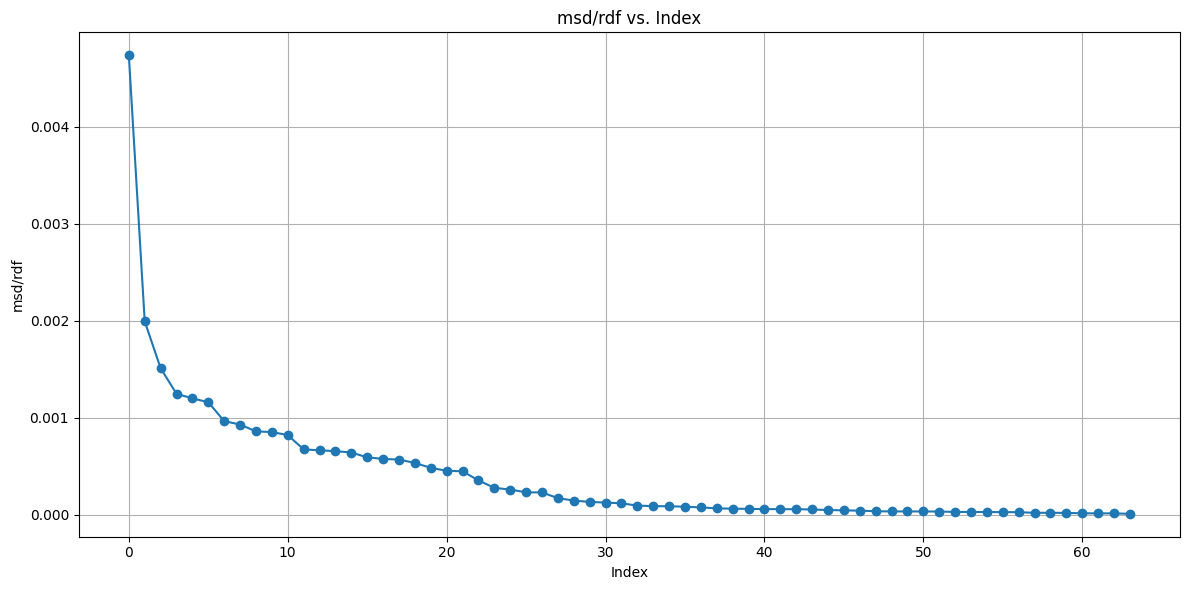

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, merged_df['msd_slope'], marker='o')
plt.xlabel("Index")
plt.ylabel("msd/rdf")
plt.title("msd/rdf vs. Index")
plt.grid(True)
plt.tight_layout()
plt.show()